<font size="30">---------------</font>
<font size="30">Data processing</font>
<font size="30">---------------</font>

<font size="30">1.0 Prepare data</font>

In [264]:
from pymongo import MongoClient

try: 
    client = MongoClient()
    print("Connected successfully!!!") 
except:
    print("Could not connect to MongoDB") 

db = client.job_advert_db #select database
collection = db.job_advert #select collection to insert

Connected successfully!!!


In [265]:
 from bson.json_util import dumps

In [266]:
job_advert_collection = collection.find({})
print("Amount of data collected:" , job_advert_collection.count())

job_adverts = []

for ja in job_advert_collection:
    job_adverts.append(ja['desc'])

C:\Users\uSER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


Amount of data collected: 4827


<font size="30">2.0 Data Preprocessing</font>

In [267]:
import re, string, unicodedata
import nltk
import contractions #expand the contractions "you're -> you are"
import inflect #convert plural to singular nouns
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords #filter english words "is", "this", "there", etc.
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import tqdm

In [268]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

2.1 Denoise Job Descriptions

In [269]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    processed_text = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        text = strip_html(t)
        text = remove_between_square_brackets(t)
        processed_text.append(text)
        pbar.update(1)
    pbar.close()
    return processed_text

In [270]:
job_adverts = denoise_text(job_adverts)

100%|████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 4841.02it/s]


2.2 Replace contractions in string

In [271]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    text_arr = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        t = contractions.fix(t)
        text_arr.append(t)
        pbar.update(1)
    pbar.close()
    return text_arr

In [272]:
job_adverts = replace_contractions(job_adverts)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [01:02<00:00, 76.86it/s]


In [273]:
len(job_adverts)
print(job_adverts[:2])

['Leading Local EnterpriseUnderstand current processes and valuable outcomesAble to structure a large amount of information within a process frameworkJob scopeMapping/Reviewing existing business processes and “re-imagine” improved ones by maximizing customer value while minimizing waste and incorporating automation.Facilitate/lead process workshops that involve eliciting process requirements and liaising with usersAbility to interpret business requirements into digital solution.Create project plans that contain project goals, milestones, and resourcesMonitor, measure and provide feedback on process performanceLiaise with management to coordinate process improvement project activitiesRequirements:Enjoys variety at work as this is a wide-ranging role immersing in a variety of different projects, and able see the big picture.Work with other business teams and Digital Department to figure out the best way to design new processes and solve process-related problems.Strong analytical backgrou

2.3 Tokenization

In [274]:
temp_arr = []
pbar = tqdm.tqdm(total=len(job_adverts))
for ja in job_adverts:
    temp_arr.append(nltk.word_tokenize(ja))
    pbar.update(1)
job_adverts = temp_arr
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:26<00:00, 181.60it/s]


In [275]:
len(job_adverts)
print(job_adverts[:2])

[['Leading', 'Local', 'EnterpriseUnderstand', 'current', 'processes', 'and', 'valuable', 'outcomesAble', 'to', 'structure', 'a', 'large', 'amount', 'of', 'information', 'within', 'a', 'process', 'frameworkJob', 'scopeMapping/Reviewing', 'existing', 'business', 'processes', 'and', '“', 're-imagine', '”', 'improved', 'ones', 'by', 'maximizing', 'customer', 'value', 'while', 'minimizing', 'waste', 'and', 'incorporating', 'automation.Facilitate/lead', 'process', 'workshops', 'that', 'involve', 'eliciting', 'process', 'requirements', 'and', 'liaising', 'with', 'usersAbility', 'to', 'interpret', 'business', 'requirements', 'into', 'digital', 'solution.Create', 'project', 'plans', 'that', 'contain', 'project', 'goals', ',', 'milestones', ',', 'and', 'resourcesMonitor', ',', 'measure', 'and', 'provide', 'feedback', 'on', 'process', 'performanceLiaise', 'with', 'management', 'to', 'coordinate', 'process', 'improvement', 'project', 'activitiesRequirements', ':', 'Enjoys', 'variety', 'at', 'work'

2.4 Normalization ((1) stemming, (2) lemmatization, and (3) everything else)

In [276]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def remove_useless_words(words):
    useless_words = ['expery']
    for uw in range(len(useless_words)):
        for word in words:
            if(word == useless_words[uw]):
                words.remove(useless_words[uw])
    return words

def normalize(words):
    pbar = tqdm.tqdm(total=len(words))
    word_arr = []
    for word in words:
        word = remove_non_ascii(word)
        word = to_lowercase(word)
        word = remove_punctuation(word)
        word = replace_numbers(word)
        word = remove_stopwords(word)
        word = stem_words(word)
        word = lemmatize_verbs(word)
        word = remove_useless_words(word)
        word_arr.append(word)
        pbar.update(1)
    pbar.close()
    return word_arr

In [263]:
words = ['testing', 'experiences', 'automated', 'hardworking', 'hardware', 'man', 'management']
words = stem_words(words)
words = lemmatize_verbs(words)
words = remove_useless_words(words)
print(words)

['test', 'autom', 'hardwork', 'hardw', 'man', 'man']


In [277]:
job_adverts = normalize(job_adverts)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [10:18<00:00, 11.74it/s]


In [244]:
len(job_adverts)
print(job_adverts[:10])

[['loc', 'enterpriseunderstand', 'cur', 'process', 'valu', 'outcomes', 'structure', 'larg', 'amount', 'inform', 'within', 'process', 'frameworkjob', 'scopemappingreview', 'ex', 'busy', 'process', 'reimagin', 'improv', 'on', 'maxim', 'custom', 'valu', 'minim', 'wast', 'incorp', 'automationfacilitatelead', 'process', 'workshop', 'involv', 'elicit', 'process', 'requir', 'lia', 'users', 'interpret', 'busy', 'requir', 'digit', 'solutioncr', 'project', 'plan', 'contain', 'project', 'goal', 'mileston', 'resourcesmonit', 'meas', 'provid', 'feedback', 'process', 'performancelia', 'man', 'coordin', 'process', 'improv', 'project', 'activitiesrequir', 'enjoy', 'vary', 'work', 'widerang', 'rol', 'immers', 'vary', 'diff', 'project', 'abl', 'see', 'big', 'picturework', 'busy', 'team', 'digit', 'depart', 'fig', 'best', 'way', 'design', 'new', 'process', 'solv', 'processrel', 'problemsstrong', 'analys', 'background', 'problem', 'solv', 'good', 'diagram', 'commun', 'skillsknowledg', 'process', 'map', 'b

Remove useless words stick with numbers

In [278]:
import re

pbar = tqdm.tqdm(total=10)

for i in range(1,11):
    for job_advert in job_adverts:
        for i in job_advert:
            if(re.search(r'\w*\d\w*', i)):
                print(i)
                job_advert.remove(str(i))
    pbar.update(1)
pbar.close()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

18c9228
r1770238
v3
365knowledge
v3
18c9228
r1770238
18c9228
r1770238
18c9228
r1770238
18c9228
r1770238
4year
18c9228
r1770238
3year
operations35
pmpprince2
v3
8021x
office365
18c9228
r1770238
r1331229
1st
2nd
r1549842
r1655144scientec
11c5781
l2
j2eerequired
unknown5
1recent
particulars3education
background5working
employment7last
salary8expected
830am
1st
r1657371
14c7215
04c4294ea
r1873987
f5
04c4294ea
r1873987
r1660377
14c7215
08c2893tay
r1875900
linux5
6pmbedok
04c4294ea
r1107940
s4
s4
r1328976ea
13c6321
manager1
reports2
systematically3
minutes4
rm8000
contact1
60320201885for
r1877642
3d
3d
4d
5day
2rest
r1877642
45k
04c4294ea
r1765402
headcount5
7ksupport
field57
04c4294ea
r1765402
6000working
9am530pm
html5
contact1
60320201885for
9001730working
6000benefits
html5
contact1
60320201885for
sub6ghz
2g3glteltemltenbhandson
r1880372
saturdays5
1feb
31aug
16sept
minimum4
thinking2
html5
rm8500responsibilitiesinvolved
93c4957ea
r1220807
r1873831
11c5781
html5
ec2
rm8000
succeed5
v3
6p

planning4
security5
db2
r1441433
06c3126
dot1x
experience4
7good
3additional
oauth2
10k
hero4
r1655093
r1330051
r1330051
k8s
j2ee
06c3126
r1551322
18s9060registration
06c3126
r1551322
06c3126
r1551322
9am
6pm
r1877641
9am
r1877641
3rd
thong65
8787recruitment
thong65
8787recruitment
domains12
j2ee
log4j
thong65
8787recruitment
responsibilities1
standardj2ee
j2ee
html5
j2ee
06c3126
r1551322
06c3126
r1551322
javaj2ee
html5
r1548171ea
95c5411
job_000284
job_000280
7x
830am
toconverge9
r1653315
830am
toconverge9
r1653315
9am
toconverge9
r1653315
r1114179
12c6296
r1114179
12c6296
40and
7x
2x
polisy400
components3
deliverables4
tuning5
build6
management7
commitments8
engineering9
8x
730am
930am
smart400
as400
query400
2d3d
r1114179
12c6296
13c6893
3psolutionscom
p3
b2b
10m
gr1441433
developer12
html5
html5
r1110040___________________________________________helius
11c3373
068877tel
2213email
r1114179
12c6296
r1114179
12c6296
ipv6
r1441433
06c3126
job_000301
locations2
name2
location3
salary4
s

r1221300
16s8115licence
r1221300
r1221300
25k
developer017231
licw1
mmsdficos4hanaaribasuccessfactor
c4c
c4c
c4c
ecchanar3
r3
abap4
1st
ecc56hana
as400
db2
3rd
html5
j2ee
db2
r2r
rm450000
r1221300
so00038360111
3g
mli01ustmalaysiait
rm850000
rm150000
im8
r1221300
3gpp
s1cs1you
3g
4g
r1221300
you2kaleeyahoocom
equivalent5
my67474579_e5
l2l
html5
mmsdficos4hanaaribasuccessfactor
c4c
c4c
c4c
ecchanar3
r3
abap4
1st
ecc56hana
as400
db2
3rd
html5
j2ee
db2
r2r
rm15002500
rm150000
j2ee
html5
rm600000
200about
r1221300
200about
200about
200about
200about
b2b
discipline810
html5
you2kaleeyahoocom
3rd
25k
rm150000
rm400000
j2ee
d3js
3des
you2kaleeyahoocom
sage300
b2c
3rd
3des
you2kaleeyahoocom
24x7
5g
16s8115licence
iso20022
html5
javaj2ee
kl603
9155wwwensoftcomsgsingapore
db2good
db2additional
e2
l2l3
pmiprince2
3pl
s4h
s4h
rm300000
ps4
db2good
db2additional
9000normal
j2eejee
rm400000
html5
24x7
y3
rm300000
2nd3rd4th
o2o
ps4
16s8069
3rd
3rd
saml2
rm250000
r1330844
11c3837
j2ee
13month
5days
fy1

workshoprequirements1
personality3
degree4
technology5
equivalent6
position7
skills8
responsibilities1
company2
expenses3
budget4
closing5
reconciliationsrequirements1
personality3
equivalent4
analysis5
j2ee
j2ee
summary1
responsibilities1
goals2
strategy3
countermeasures4
meeting5
activitiesrequirements1
personality3
degree6
im8itsecis0
3rd
j2ee
id971we
16c7962
accountant2
assistant3
clerk4
executive5
executive6
accountant7
executive8
manager9
accountant10
executive11
manager12
supervisor13
assistant14
consultant15
director16
manager17
analyst19
officer20
director21
manager22
manager23
analyst24
clerk25
manager26
officer27
director28
manager29
manager30
director31
manager32
accountant33
analyst34
controller35
accountant36
controller37
audit38
director39
manager40
auditor41
accountant42
clerk43
analyst44
manager45
accountant46
associate47
accountant48
analyst49
associate50
director51
executive52
manager53
senior54
analyst55
director56
executive57
id1042we
no16c7962
as400
director2
assi

css3
6d
6pm
css3
6d
3d
j2ee
6pm
600pm
css3
r1767240
11g
r1767240
3rd
8451pmjob
7team
1500hr
430pm
1800hrcompany
1800hrcompany
8451pmjob
530amsalary
430pm
6pmbasic
630pm
s3
r1980748
630pmworking
6pmresponsibilities
530pm
530pm
a350
css3
k2
615pm6month
1800hrcompany
1800hrcompany
630pmworking
5pminterested
1800hrcompany
css3
html4
49k
html5
18xx
500pm
1200pm
65898787danica
smart400
css3
css3
2nd
css3
anc1
css3
12pmbackend
css3
css3
500pm
1200pm
ec2
css3strong
css3
5pm
l3
css3
css3
rpg400
anc1
anc1
css3
anc1
r1548171
css3
65898787danica
9k
ipv6
8021x
css3
css3
6pm
hero4
2nd
sp1
9x
65898787danica
65898787danica
anc1
anc1
12c
545pm
08c2893capita
anc1
30th
600pm
30th
css23
65898787danica
css3
r1114636
6pm
inspire5
6pm
inspire5
6x
6pm
545pm
6pm
430pm
smart400
css3
css3
css3
b2c
css3
s3
430pm
css3
3do
l3
anc1
anc1
j2ee
b2c
mt942
l3
12th
s3
css3
css3
10am8pm
l4
65898787faymay
12c
12c
65898787daryl
65898787daryl
65898787faymay
j2ee
65898787danica
25mn
l2
css5
830pm
65898787danica
65898787danica


 20%|████████████████▌                                                                  | 2/10 [00:31<02:40, 20.02s/it]

level4each
9sept
29xx
universities9
mvc6
800pm
200pm
800pm
200pm
2k
630pm
530pm
chef62
chef62
as400


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  3.39s/it]


Run this to backup data variable

In [279]:
import pickle
with open('job_advert_variable_dump', 'wb') as f:
    pickle.dump(job_adverts, f)

Run this to load data variable

In [245]:
import pickle
job_adverts = []
with open('job_advert_variable_dump', 'rb') as f:
    job_adverts = pickle.load(f)

<font size="30">3.0 Data Clustering</font>

3.1 Convert to numerical data

In [297]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)  
x = vectorizer.fit_transform(job_adverts)
print("shape : ", x.shape)

C:\Users\uSER\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


shape :  (4827, 30340)


In [298]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=10)
svd.fit(x)
data2D = svd.transform(x)

3.2 Finding K with Elbow method

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 31.30765964119366
start iteration
done sorting
end inner loop
Iteration 1, inertia 29.170969468255336
start iteration
done sorting
end inner loop
Iteration 2, inertia 28.483740038777064
start iteration
done sorting
end inner loop
Iteration 3, inertia 28.162538573718017
start iteration
done sorting
end inner loop
Iteration 4, inertia 27.985732746177238
start iteration
done sorting
end inner loop
Iteration 5, inertia 27.85618748432081
start iteration
done sorting
end inner loop
Iteration 6, inertia 27.745227340401883
start iteration
done sorting
end inner loop
Iteration 7, inertia 27.658469778483024
start iteration
done sorting
end inner loop
Iteration 8, inertia 27.587470191214756
start iteration
done sorting
end inner loop
Iteration 9, inertia 27.555572085228036
start iteration
done sorting
end inner loop
Iteration 10, inertia 27.538184287022048
start iteration
done sorting
end inner loop
Iteration

Iteration 17, inertia 28.31517842060197
start iteration
done sorting
end inner loop
Iteration 18, inertia 28.24977828258075
start iteration
done sorting
end inner loop
Iteration 19, inertia 28.148057231069643
start iteration
done sorting
end inner loop
Iteration 20, inertia 28.041876999521875
start iteration
done sorting
end inner loop
Iteration 21, inertia 27.900707452054924
start iteration
done sorting
end inner loop
Iteration 22, inertia 27.739383340881304
start iteration
done sorting
end inner loop
Iteration 23, inertia 27.594235251176073
start iteration
done sorting
end inner loop
Iteration 24, inertia 27.491324832848562
start iteration
done sorting
end inner loop
Iteration 25, inertia 27.409812963064773
start iteration
done sorting
end inner loop
Iteration 26, inertia 27.361169978107476
start iteration
done sorting
end inner loop
Iteration 27, inertia 27.330883365343556
start iteration
done sorting
end inner loop
Iteration 28, inertia 27.3122695677327
start iteration
done sorting

Iteration 38, inertia 22.945693994234404
start iteration
done sorting
end inner loop
Iteration 39, inertia 22.942284839814675
start iteration
done sorting
end inner loop
Iteration 40, inertia 22.93886297761884
start iteration
done sorting
end inner loop
Iteration 41, inertia 22.935084587028545
start iteration
done sorting
end inner loop
Iteration 42, inertia 22.932948752658625
start iteration
done sorting
end inner loop
Iteration 43, inertia 22.931984489044943
start iteration
done sorting
end inner loop
Iteration 44, inertia 22.931180558773345
start iteration
done sorting
end inner loop
Iteration 45, inertia 22.930445418972422
start iteration
done sorting
end inner loop
Iteration 46, inertia 22.929906421425894
start iteration
done sorting
end inner loop
Iteration 47, inertia 22.929250770229448
center shift 1.029651e-03 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 25.632635605986543
start iteration
done sorting
en

start iteration
done sorting
end inner loop
Iteration 27, inertia 19.532931114729813
start iteration
done sorting
end inner loop
Iteration 28, inertia 19.531741433133476
start iteration
done sorting
end inner loop
Iteration 29, inertia 19.530755946808362
start iteration
done sorting
end inner loop
Iteration 30, inertia 19.529801933345762
start iteration
done sorting
end inner loop
Iteration 31, inertia 19.529220670462713
start iteration
done sorting
end inner loop
Iteration 32, inertia 19.528728177342867
start iteration
done sorting
end inner loop
Iteration 33, inertia 19.527948013679687
start iteration
done sorting
end inner loop
Iteration 34, inertia 19.527547832243684
start iteration
done sorting
end inner loop
Iteration 35, inertia 19.5271579845403
center shift 9.823609e-04 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 22.778836583369376
start iteration
done sorting
end inner loop
Iteration 1, inertia 20.76965

Iteration 17, inertia 19.69483669225043
start iteration
done sorting
end inner loop
Iteration 18, inertia 19.66516114751252
start iteration
done sorting
end inner loop
Iteration 19, inertia 19.59880537620484
start iteration
done sorting
end inner loop
Iteration 20, inertia 19.53825111948838
start iteration
done sorting
end inner loop
Iteration 21, inertia 19.492697293473316
start iteration
done sorting
end inner loop
Iteration 22, inertia 19.45714896011124
start iteration
done sorting
end inner loop
Iteration 23, inertia 19.41485264810341
start iteration
done sorting
end inner loop
Iteration 24, inertia 19.381861035710806
start iteration
done sorting
end inner loop
Iteration 25, inertia 19.356612271930157
start iteration
done sorting
end inner loop
Iteration 26, inertia 19.322924697736436
start iteration
done sorting
end inner loop
Iteration 27, inertia 19.29260030639586
start iteration
done sorting
end inner loop
Iteration 28, inertia 19.27374880252009
start iteration
done sorting
end

start iteration
done sorting
end inner loop
Iteration 7, inertia 17.520846686218295
start iteration
done sorting
end inner loop
Iteration 8, inertia 17.50466974022752
start iteration
done sorting
end inner loop
Iteration 9, inertia 17.499656344279494
start iteration
done sorting
end inner loop
Iteration 10, inertia 17.49832817242263
start iteration
done sorting
end inner loop
Iteration 11, inertia 17.497541196283958
start iteration
done sorting
end inner loop
Iteration 12, inertia 17.49744890105172
center shift 3.280519e-04 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 19.86551510186564
start iteration
done sorting
end inner loop
Iteration 1, inertia 18.741774256481143
start iteration
done sorting
end inner loop
Iteration 2, inertia 18.235510644264217
start iteration
done sorting
end inner loop
Iteration 3, inertia 17.974613668799172
start iteration
done sorting
end inner loop
Iteration 4, inertia 17.8416876113090

Iteration 37, inertia 17.003268528555065
start iteration
done sorting
end inner loop
Iteration 38, inertia 16.99731453640497
start iteration
done sorting
end inner loop
Iteration 39, inertia 16.99297067935828
start iteration
done sorting
end inner loop
Iteration 40, inertia 16.988367302375813
start iteration
done sorting
end inner loop
Iteration 41, inertia 16.984833268356898
start iteration
done sorting
end inner loop
Iteration 42, inertia 16.98209816555466
start iteration
done sorting
end inner loop
Iteration 43, inertia 16.98024075559852
start iteration
done sorting
end inner loop
Iteration 44, inertia 16.97841059585337
start iteration
done sorting
end inner loop
Iteration 45, inertia 16.977734363588546
start iteration
done sorting
end inner loop
Iteration 46, inertia 16.97741456375687
start iteration
done sorting
end inner loop
Iteration 47, inertia 16.977228513337074
center shift 1.051129e-03 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end in

end inner loop
Iteration 12, inertia 14.258323490065775
start iteration
done sorting
end inner loop
Iteration 13, inertia 14.25089749828701
start iteration
done sorting
end inner loop
Iteration 14, inertia 14.244875839063209
start iteration
done sorting
end inner loop
Iteration 15, inertia 14.237342699254391
start iteration
done sorting
end inner loop
Iteration 16, inertia 14.230582842373343
start iteration
done sorting
end inner loop
Iteration 17, inertia 14.224406476530252
start iteration
done sorting
end inner loop
Iteration 18, inertia 14.22125629670889
start iteration
done sorting
end inner loop
Iteration 19, inertia 14.218668664959253
start iteration
done sorting
end inner loop
Iteration 20, inertia 14.216884424269864
start iteration
done sorting
end inner loop
Iteration 21, inertia 14.214785375514403
start iteration
done sorting
end inner loop
Iteration 22, inertia 14.213452245665152
start iteration
done sorting
end inner loop
Iteration 23, inertia 14.212626427196582
start itera

done sorting
end inner loop
Iteration 37, inertia 12.79453513441148
start iteration
done sorting
end inner loop
Iteration 38, inertia 12.792471524891864
start iteration
done sorting
end inner loop
Iteration 39, inertia 12.791537799321862
start iteration
done sorting
end inner loop
Iteration 40, inertia 12.790808004340906
start iteration
done sorting
end inner loop
Iteration 41, inertia 12.790096677185867
start iteration
done sorting
end inner loop
Iteration 42, inertia 12.789756432782056
start iteration
done sorting
end inner loop
Iteration 43, inertia 12.789637519350773
center shift 9.905327e-04 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 14.992908971828118
start iteration
done sorting
end inner loop
Iteration 1, inertia 14.16317568177044
start iteration
done sorting
end inner loop
Iteration 2, inertia 13.843065318443287
start iteration
done sorting
end inner loop
Iteration 3, inertia 13.624777975784529
start i

Iteration 11, inertia 11.951157789742188
start iteration
done sorting
end inner loop
Iteration 12, inertia 11.943691412417111
start iteration
done sorting
end inner loop
Iteration 13, inertia 11.935562959606823
start iteration
done sorting
end inner loop
Iteration 14, inertia 11.92461018675985
start iteration
done sorting
end inner loop
Iteration 15, inertia 11.915412233077756
start iteration
done sorting
end inner loop
Iteration 16, inertia 11.906741622936249
start iteration
done sorting
end inner loop
Iteration 17, inertia 11.901050189478855
start iteration
done sorting
end inner loop
Iteration 18, inertia 11.894965685445353
start iteration
done sorting
end inner loop
Iteration 19, inertia 11.890476861551674
start iteration
done sorting
end inner loop
Iteration 20, inertia 11.889160910586373
start iteration
done sorting
end inner loop
Iteration 21, inertia 11.888304441366822
start iteration
done sorting
end inner loop
Iteration 22, inertia 11.88809936812738
center shift 9.883795e-04 

done sorting
end inner loop
Iteration 20, inertia 11.070355821865588
start iteration
done sorting
end inner loop
Iteration 21, inertia 11.068255400845947
start iteration
done sorting
end inner loop
Iteration 22, inertia 11.06594784775825
start iteration
done sorting
end inner loop
Iteration 23, inertia 11.064143612935107
start iteration
done sorting
end inner loop
Iteration 24, inertia 11.06235582989039
start iteration
done sorting
end inner loop
Iteration 25, inertia 11.061530367416134
start iteration
done sorting
end inner loop
Iteration 26, inertia 11.061395163955554
start iteration
done sorting
end inner loop
Iteration 27, inertia 11.061204283875924
center shift 8.809326e-04 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 12.200515754020017
start iteration
done sorting
end inner loop
Iteration 1, inertia 11.777815899802281
start iteration
done sorting
end inner loop
Iteration 2, inertia 11.526330458885923
start 

start iteration
done sorting
end inner loop
Iteration 26, inertia 10.420887977527409
start iteration
done sorting
end inner loop
Iteration 27, inertia 10.413373721461863
start iteration
done sorting
end inner loop
Iteration 28, inertia 10.403421137830945
start iteration
done sorting
end inner loop
Iteration 29, inertia 10.388766230699021
start iteration
done sorting
end inner loop
Iteration 30, inertia 10.371249653563767
start iteration
done sorting
end inner loop
Iteration 31, inertia 10.35014685920487
start iteration
done sorting
end inner loop
Iteration 32, inertia 10.32029703854258
start iteration
done sorting
end inner loop
Iteration 33, inertia 10.292740883522274
start iteration
done sorting
end inner loop
Iteration 34, inertia 10.27429949637628
start iteration
done sorting
end inner loop
Iteration 35, inertia 10.254891465888809
start iteration
done sorting
end inner loop
Iteration 36, inertia 10.239540776101617
start iteration
done sorting
end inner loop
Iteration 37, inertia 10

Iteration 29, inertia 9.14093585209884
start iteration
done sorting
end inner loop
Iteration 30, inertia 9.140803579435293
start iteration
done sorting
end inner loop
Iteration 31, inertia 9.140065271435319
start iteration
done sorting
end inner loop
Iteration 32, inertia 9.139397108928009
start iteration
done sorting
end inner loop
Iteration 33, inertia 9.13903188061286
start iteration
done sorting
end inner loop
Iteration 34, inertia 9.138929367801737
center shift 8.962486e-04 within tolerance 1.143555e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9.94204878152323
start iteration
done sorting
end inner loop
Iteration 1, inertia 9.597864803799077
start iteration
done sorting
end inner loop
Iteration 2, inertia 9.506440587339188
start iteration
done sorting
end inner loop
Iteration 3, inertia 9.460557480641997
start iteration
done sorting
end inner loop
Iteration 4, inertia 9.423794115085073
start iteration
done sorting
end inner loop
Iter

done sorting
end inner loop
Iteration 20, inertia 8.704096326661169
start iteration
done sorting
end inner loop
Iteration 21, inertia 8.697095105546078
start iteration
done sorting
end inner loop
Iteration 22, inertia 8.691065167347226
start iteration
done sorting
end inner loop
Iteration 23, inertia 8.684862373303378
start iteration
done sorting
end inner loop
Iteration 24, inertia 8.675827607609877
start iteration
done sorting
end inner loop
Iteration 25, inertia 8.669789683318104
start iteration
done sorting
end inner loop
Iteration 26, inertia 8.666298068616614
start iteration
done sorting
end inner loop
Iteration 27, inertia 8.664854176306523
start iteration
done sorting
end inner loop
Iteration 28, inertia 8.661187673832831
start iteration
done sorting
end inner loop
Iteration 29, inertia 8.657633854349355
start iteration
done sorting
end inner loop
Iteration 30, inertia 8.655707303673513
start iteration
done sorting
end inner loop
Iteration 31, inertia 8.654496020069733
start it

Iteration 4, inertia 8.53086738632481
start iteration
done sorting
end inner loop
Iteration 5, inertia 8.451166183345892
start iteration
done sorting
end inner loop
Iteration 6, inertia 8.392962581611046
start iteration
done sorting
end inner loop
Iteration 7, inertia 8.35183417952424
start iteration
done sorting
end inner loop
Iteration 8, inertia 8.320474628077
start iteration
done sorting
end inner loop
Iteration 9, inertia 8.290159930409146
start iteration
done sorting
end inner loop
Iteration 10, inertia 8.269199898746336
start iteration
done sorting
end inner loop
Iteration 11, inertia 8.255470989898772
start iteration
done sorting
end inner loop
Iteration 12, inertia 8.239930821082762
start iteration
done sorting
end inner loop
Iteration 13, inertia 8.22951735415273
start iteration
done sorting
end inner loop
Iteration 14, inertia 8.224369302410143
start iteration
done sorting
end inner loop
Iteration 15, inertia 8.21922880678314
start iteration
done sorting
end inner loop
Itera

Iteration 3, inertia 8.517678079945105
start iteration
done sorting
end inner loop
Iteration 4, inertia 8.487157886847788
start iteration
done sorting
end inner loop
Iteration 5, inertia 8.46676495092291
start iteration
done sorting
end inner loop
Iteration 6, inertia 8.45143519467148
start iteration
done sorting
end inner loop
Iteration 7, inertia 8.436587083445488
start iteration
done sorting
end inner loop
Iteration 8, inertia 8.423382165903927
start iteration
done sorting
end inner loop
Iteration 9, inertia 8.40909476700275
start iteration
done sorting
end inner loop
Iteration 10, inertia 8.397719462013034
start iteration
done sorting
end inner loop
Iteration 11, inertia 8.388470360451809
start iteration
done sorting
end inner loop
Iteration 12, inertia 8.38169691478581
start iteration
done sorting
end inner loop
Iteration 13, inertia 8.376059306677337
start iteration
done sorting
end inner loop
Iteration 14, inertia 8.368092405066902
start iteration
done sorting
end inner loop
Ite

end inner loop
Iteration 21, inertia 7.6235816763859745
start iteration
done sorting
end inner loop
Iteration 22, inertia 7.619328431674836
start iteration
done sorting
end inner loop
Iteration 23, inertia 7.616009399417621
start iteration
done sorting
end inner loop
Iteration 24, inertia 7.614004565444469
start iteration
done sorting
end inner loop
Iteration 25, inertia 7.611227814205002
start iteration
done sorting
end inner loop
Iteration 26, inertia 7.607641576640448
start iteration
done sorting
end inner loop
Iteration 27, inertia 7.605227972313531
start iteration
done sorting
end inner loop
Iteration 28, inertia 7.602879686143679
start iteration
done sorting
end inner loop
Iteration 29, inertia 7.601536491168845
start iteration
done sorting
end inner loop
Iteration 30, inertia 7.600531641541979
start iteration
done sorting
end inner loop
Iteration 31, inertia 7.599576719315419
start iteration
done sorting
end inner loop
Iteration 32, inertia 7.5990275867639525
start iteration
don

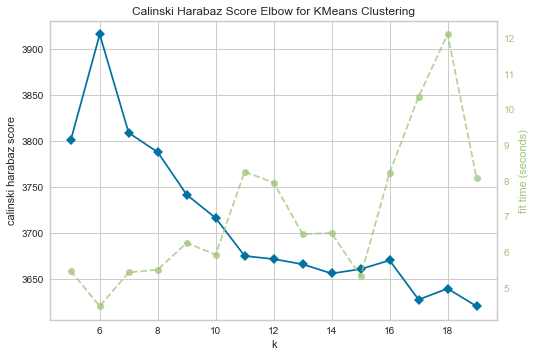

In [301]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)
visualizer = KElbowVisualizer(kmeans, k=(5,20), metric='calinski_harabaz')

visualizer.fit(data2D)    # Fit the data to the visualizer
visualizer.poof(outpath="elbow(K=10).png")

In [296]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)

visualizer = KElbowVisualizer(kmeans, k=(50,100))

visualizer.fit(x)    # Fit the data to the visualizer
visualizer.poof(outpath="elbow(K=100).png")

Initialization complete
Iteration  0, inertia 4701.258
Iteration  1, inertia 4288.919
Iteration  2, inertia 4211.718
Iteration  3, inertia 4183.396
Iteration  4, inertia 4176.431
Iteration  5, inertia 4172.687
Iteration  6, inertia 4168.548
Iteration  7, inertia 4164.359
Iteration  8, inertia 4157.682
Iteration  9, inertia 4149.874
Iteration 10, inertia 4143.232
Iteration 11, inertia 4135.608
Iteration 12, inertia 4127.809
Iteration 13, inertia 4122.321
Iteration 14, inertia 4117.528
Iteration 15, inertia 4113.153
Iteration 16, inertia 4110.605
Iteration 17, inertia 4109.801
Iteration 18, inertia 4109.142
Iteration 19, inertia 4108.759
Iteration 20, inertia 4108.237
Iteration 21, inertia 4106.505
Iteration 22, inertia 4103.454
Iteration 23, inertia 4101.882
Iteration 24, inertia 4101.690
Iteration 25, inertia 4101.634
Iteration 26, inertia 4101.596
Iteration 27, inertia 4101.588
Iteration 28, inertia 4101.586
Converged at iteration 28: center shift 0.000000e+00 within tolerance 3.05217

Iteration 14, inertia 4115.689
Iteration 15, inertia 4111.323
Iteration 16, inertia 4108.774
Iteration 17, inertia 4107.953
Iteration 18, inertia 4107.308
Iteration 19, inertia 4106.911
Iteration 20, inertia 4106.389
Iteration 21, inertia 4104.647
Iteration 22, inertia 4101.608
Iteration 23, inertia 4100.025
Iteration 24, inertia 4099.843
Iteration 25, inertia 4099.770
Iteration 26, inertia 4099.768
Converged at iteration 26: center shift 0.000000e+00 within tolerance 3.052178e-09
Initialization complete
Iteration  0, inertia 7209.371
Iteration  1, inertia 4035.035
Iteration  2, inertia 3989.730
Iteration  3, inertia 3972.483
Iteration  4, inertia 3963.534
Iteration  5, inertia 3957.199
Iteration  6, inertia 3953.805
Iteration  7, inertia 3950.779
Iteration  8, inertia 3947.298
Iteration  9, inertia 3944.568
Iteration 10, inertia 3942.998
Iteration 11, inertia 3941.877
Iteration 12, inertia 3940.531
Iteration 13, inertia 3938.771
Iteration 14, inertia 3936.673
Iteration 15, inertia 393

Iteration  0, inertia 4695.050
Iteration  1, inertia 4282.591
Iteration  2, inertia 4205.180
Iteration  3, inertia 4176.859
Iteration  4, inertia 4169.895
Iteration  5, inertia 4166.152
Iteration  6, inertia 4162.014
Iteration  7, inertia 4157.832
Iteration  8, inertia 4151.163
Iteration  9, inertia 4143.354
Iteration 10, inertia 4136.730
Iteration 11, inertia 4129.177
Iteration 12, inertia 4121.331
Iteration 13, inertia 4115.976
Iteration 14, inertia 4111.109
Iteration 15, inertia 4106.681
Iteration 16, inertia 4104.132
Iteration 17, inertia 4103.332
Iteration 18, inertia 4102.700
Iteration 19, inertia 4102.303
Iteration 20, inertia 4101.787
Iteration 21, inertia 4100.051
Iteration 22, inertia 4097.019
Iteration 23, inertia 4095.440
Iteration 24, inertia 4095.210
Iteration 25, inertia 4095.129
Iteration 26, inertia 4095.100
Iteration 27, inertia 4095.048
Iteration 28, inertia 4095.020
Iteration 29, inertia 4095.001
Iteration 30, inertia 4094.999
Converged at iteration 30: center shift

KeyboardInterrupt: 

Initialization complete
Iteration  0, inertia 9074.822
Iteration  1, inertia 4588.082
Iteration  2, inertia 4575.603
Iteration  3, inertia 4573.797
Iteration  4, inertia 4571.938
Iteration  5, inertia 4570.488
Iteration  6, inertia 4569.431
Iteration  7, inertia 4568.791
Iteration  8, inertia 4568.472
Iteration  9, inertia 4568.228
Iteration 10, inertia 4568.172
Iteration 11, inertia 4568.140
Iteration 12, inertia 4568.115
Iteration 13, inertia 4568.061
Iteration 14, inertia 4567.855
Iteration 15, inertia 4567.549
Iteration 16, inertia 4567.005
Iteration 17, inertia 4566.879
Iteration 18, inertia 4566.833
Iteration 19, inertia 4566.817
Iteration 20, inertia 4566.802
Iteration 21, inertia 4566.782
Iteration 22, inertia 4566.767
Iteration 23, inertia 4566.766
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8880.105
Iteration  1, inertia 4581.609
Iteration  2, inertia 4569.672
Iteration  3, inertia 4568.636
I

Iteration 12, inertia 4526.116
Iteration 13, inertia 4526.109
Iteration 14, inertia 4526.095
Iteration 15, inertia 4526.079
Iteration 16, inertia 4526.074
Iteration 17, inertia 4526.070
Iteration 18, inertia 4526.065
Iteration 19, inertia 4526.062
Iteration 20, inertia 4526.060
Iteration 21, inertia 4526.060
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8854.185
Iteration  1, inertia 4554.221
Iteration  2, inertia 4541.770
Iteration  3, inertia 4539.621
Iteration  4, inertia 4539.206
Iteration  5, inertia 4539.035
Iteration  6, inertia 4538.955
Iteration  7, inertia 4538.929
Iteration  8, inertia 4538.920
Iteration  9, inertia 4538.912
Iteration 10, inertia 4538.910
Iteration 11, inertia 4538.899
Iteration 12, inertia 4538.894
Iteration 13, inertia 4538.890
Iteration 14, inertia 4538.889
Iteration 15, inertia 4538.888
Converged at iteration 15: center shift 0.000000e+00 within tolerance 2.268293e-09
Init

Iteration 26, inertia 4498.815
Iteration 27, inertia 4498.797
Iteration 28, inertia 4498.771
Iteration 29, inertia 4498.737
Iteration 30, inertia 4498.486
Iteration 31, inertia 4498.279
Iteration 32, inertia 4498.196
Iteration 33, inertia 4498.123
Iteration 34, inertia 4498.078
Iteration 35, inertia 4498.062
Iteration 36, inertia 4498.053
Iteration 37, inertia 4498.050
Converged at iteration 37: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8525.695
Iteration  1, inertia 4542.284
Iteration  2, inertia 4527.501
Iteration  3, inertia 4523.917
Iteration  4, inertia 4522.114
Iteration  5, inertia 4520.160
Iteration  6, inertia 4518.551
Iteration  7, inertia 4518.052
Iteration  8, inertia 4517.786
Iteration  9, inertia 4517.308
Iteration 10, inertia 4516.958
Iteration 11, inertia 4516.784
Iteration 12, inertia 4516.691
Iteration 13, inertia 4516.627
Iteration 14, inertia 4516.537
Iteration 15, inertia 4516.486
Iteration 16, inertia 451

Iteration  2, inertia 4481.024
Iteration  3, inertia 4467.547
Iteration  4, inertia 4464.106
Iteration  5, inertia 4461.913
Iteration  6, inertia 4459.737
Iteration  7, inertia 4458.138
Iteration  8, inertia 4457.330
Iteration  9, inertia 4456.872
Iteration 10, inertia 4456.471
Iteration 11, inertia 4456.187
Iteration 12, inertia 4455.863
Iteration 13, inertia 4455.622
Iteration 14, inertia 4455.200
Iteration 15, inertia 4454.472
Iteration 16, inertia 4453.026
Iteration 17, inertia 4452.198
Iteration 18, inertia 4451.880
Iteration 19, inertia 4451.752
Iteration 20, inertia 4451.702
Iteration 21, inertia 4451.688
Iteration 22, inertia 4451.598
Iteration 23, inertia 4451.572
Iteration 24, inertia 4451.564
Iteration 25, inertia 4451.560
Iteration 26, inertia 4451.558
Iteration 27, inertia 4451.552
Iteration 28, inertia 4451.542
Converged at iteration 28: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8369.426
Iteration  1, inertia 450

Iteration 15, inertia 4428.085
Iteration 16, inertia 4427.897
Iteration 17, inertia 4427.808
Iteration 18, inertia 4427.672
Iteration 19, inertia 4427.608
Iteration 20, inertia 4427.536
Iteration 21, inertia 4427.469
Iteration 22, inertia 4427.419
Iteration 23, inertia 4427.330
Iteration 24, inertia 4427.194
Iteration 25, inertia 4426.982
Iteration 26, inertia 4426.782
Iteration 27, inertia 4426.432
Iteration 28, inertia 4425.917
Iteration 29, inertia 4425.543
Iteration 30, inertia 4425.285
Iteration 31, inertia 4425.088
Iteration 32, inertia 4424.968
Iteration 33, inertia 4424.912
Iteration 34, inertia 4424.889
Iteration 35, inertia 4424.884
Iteration 36, inertia 4424.881
Converged at iteration 36: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8505.667
Iteration  1, inertia 4496.497
Iteration  2, inertia 4475.462
Iteration  3, inertia 4468.007
Iteration  4, inertia 4461.156
Iteration  5, inertia 4453.263
Iteration  6, inertia 443

Iteration  0, inertia 8364.494
Iteration  1, inertia 4476.141
Iteration  2, inertia 4451.234
Iteration  3, inertia 4434.741
Iteration  4, inertia 4422.176
Iteration  5, inertia 4414.937
Iteration  6, inertia 4413.508
Iteration  7, inertia 4413.048
Iteration  8, inertia 4412.476
Iteration  9, inertia 4411.971
Iteration 10, inertia 4411.645
Iteration 11, inertia 4411.249
Iteration 12, inertia 4411.027
Iteration 13, inertia 4410.720
Iteration 14, inertia 4410.302
Iteration 15, inertia 4409.838
Iteration 16, inertia 4409.012
Iteration 17, inertia 4407.250
Iteration 18, inertia 4406.041
Iteration 19, inertia 4405.601
Iteration 20, inertia 4404.834
Iteration 21, inertia 4404.486
Iteration 22, inertia 4404.357
Iteration 23, inertia 4404.248
Iteration 24, inertia 4404.218
Iteration 25, inertia 4404.172
Iteration 26, inertia 4404.106
Iteration 27, inertia 4404.071
Iteration 28, inertia 4403.994
Iteration 29, inertia 4403.912
Iteration 30, inertia 4403.854
Iteration 31, inertia 4403.779
Iteratio

Iteration 26, inertia 4373.340
Iteration 27, inertia 4373.331
Iteration 28, inertia 4373.327
Converged at iteration 28: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8317.296
Iteration  1, inertia 4434.277
Iteration  2, inertia 4391.052
Iteration  3, inertia 4376.675
Iteration  4, inertia 4371.505
Iteration  5, inertia 4369.773
Iteration  6, inertia 4368.773
Iteration  7, inertia 4368.163
Iteration  8, inertia 4367.801
Iteration  9, inertia 4367.609
Iteration 10, inertia 4367.482
Iteration 11, inertia 4367.257
Iteration 12, inertia 4367.166
Iteration 13, inertia 4367.054
Iteration 14, inertia 4366.946
Iteration 15, inertia 4366.898
Iteration 16, inertia 4366.882
Iteration 17, inertia 4366.880
Iteration 18, inertia 4366.878
Iteration 19, inertia 4366.873
Iteration 20, inertia 4366.868
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8379.298
Iteration  

Iteration 16, inertia 4362.373
Iteration 17, inertia 4362.357
Iteration 18, inertia 4362.351
Converged at iteration 18: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8311.371
Iteration  1, inertia 4427.415
Iteration  2, inertia 4397.124
Iteration  3, inertia 4384.766
Iteration  4, inertia 4377.192
Iteration  5, inertia 4368.961
Iteration  6, inertia 4361.230
Iteration  7, inertia 4358.231
Iteration  8, inertia 4356.659
Iteration  9, inertia 4355.797
Iteration 10, inertia 4355.421
Iteration 11, inertia 4355.184
Iteration 12, inertia 4355.062
Iteration 13, inertia 4354.997
Iteration 14, inertia 4354.968
Iteration 15, inertia 4354.959
Iteration 16, inertia 4354.952
Converged at iteration 16: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 4806.313
Iteration  1, inertia 4579.846
Iteration  2, inertia 4577.242
Iteration  3, inertia 4572.754
Iteration  4, inertia 4567.618
Iteration  

Iteration 13, inertia 4355.955
Iteration 14, inertia 4355.787
Iteration 15, inertia 4355.666
Iteration 16, inertia 4355.568
Iteration 17, inertia 4355.478
Iteration 18, inertia 4355.176
Iteration 19, inertia 4355.048
Iteration 20, inertia 4354.973
Iteration 21, inertia 4354.912
Iteration 22, inertia 4354.715
Iteration 23, inertia 4354.220
Iteration 24, inertia 4354.076
Iteration 25, inertia 4354.010
Iteration 26, inertia 4353.850
Iteration 27, inertia 4353.733
Iteration 28, inertia 4353.613
Iteration 29, inertia 4353.482
Iteration 30, inertia 4353.430
Iteration 31, inertia 4353.374
Iteration 32, inertia 4353.271
Iteration 33, inertia 4353.250
Iteration 34, inertia 4353.244
Converged at iteration 34: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8277.547
Iteration  1, inertia 4431.174
Iteration  2, inertia 4387.514
Iteration  3, inertia 4375.645
Iteration  4, inertia 4368.459
Iteration  5, inertia 4364.125
Iteration  6, inertia 436

Iteration  3, inertia 4356.776
Iteration  4, inertia 4339.113
Iteration  5, inertia 4331.561
Iteration  6, inertia 4328.648
Iteration  7, inertia 4327.404
Iteration  8, inertia 4326.893
Iteration  9, inertia 4326.296
Iteration 10, inertia 4325.480
Iteration 11, inertia 4324.812
Iteration 12, inertia 4324.189
Iteration 13, inertia 4323.530
Iteration 14, inertia 4322.987
Iteration 15, inertia 4322.588
Iteration 16, inertia 4322.205
Iteration 17, inertia 4321.765
Iteration 18, inertia 4321.433
Iteration 19, inertia 4321.116
Iteration 20, inertia 4320.922
Iteration 21, inertia 4320.652
Iteration 22, inertia 4320.298
Iteration 23, inertia 4320.184
Iteration 24, inertia 4320.080
Iteration 25, inertia 4319.959
Iteration 26, inertia 4319.893
Iteration 27, inertia 4319.811
Iteration 28, inertia 4319.724
Iteration 29, inertia 4319.643
Iteration 30, inertia 4319.572
Iteration 31, inertia 4319.450
Iteration 32, inertia 4319.231
Iteration 33, inertia 4319.038
Iteration 34, inertia 4318.938
Iteratio

Iteration 10, inertia 4328.847
Iteration 11, inertia 4328.513
Iteration 12, inertia 4328.300
Iteration 13, inertia 4328.180
Iteration 14, inertia 4328.141
Iteration 15, inertia 4328.028
Iteration 16, inertia 4327.503
Iteration 17, inertia 4327.091
Iteration 18, inertia 4326.910
Iteration 19, inertia 4326.814
Iteration 20, inertia 4326.774
Iteration 21, inertia 4326.726
Iteration 22, inertia 4326.695
Iteration 23, inertia 4326.691
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8181.122
Iteration  1, inertia 4366.694
Iteration  2, inertia 4339.117
Iteration  3, inertia 4328.942
Iteration  4, inertia 4323.222
Iteration  5, inertia 4319.828
Iteration  6, inertia 4316.807
Iteration  7, inertia 4313.839
Iteration  8, inertia 4312.465
Iteration  9, inertia 4311.924
Iteration 10, inertia 4311.463
Iteration 11, inertia 4311.195
Iteration 12, inertia 4310.914
Iteration 13, inertia 4310.691
Iteration 14, inertia 431

Iteration  2, inertia 4347.922
Iteration  3, inertia 4330.410
Iteration  4, inertia 4320.155
Iteration  5, inertia 4313.780
Iteration  6, inertia 4310.315
Iteration  7, inertia 4308.250
Iteration  8, inertia 4307.041
Iteration  9, inertia 4306.446
Iteration 10, inertia 4306.134
Iteration 11, inertia 4305.901
Iteration 12, inertia 4305.748
Iteration 13, inertia 4305.517
Iteration 14, inertia 4305.272
Iteration 15, inertia 4305.115
Iteration 16, inertia 4305.032
Iteration 17, inertia 4304.922
Iteration 18, inertia 4304.791
Iteration 19, inertia 4304.707
Iteration 20, inertia 4304.544
Iteration 21, inertia 4304.295
Iteration 22, inertia 4304.249
Iteration 23, inertia 4304.200
Iteration 24, inertia 4304.154
Iteration 25, inertia 4304.055
Iteration 26, inertia 4304.053
Iteration 27, inertia 4304.049
Iteration 28, inertia 4304.046
Iteration 29, inertia 4304.043
Converged at iteration 29: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 818

Iteration  6, inertia 4290.937
Iteration  7, inertia 4289.741
Iteration  8, inertia 4288.782
Iteration  9, inertia 4288.217
Iteration 10, inertia 4287.910
Iteration 11, inertia 4287.739
Iteration 12, inertia 4287.673
Iteration 13, inertia 4287.639
Iteration 14, inertia 4287.573
Iteration 15, inertia 4287.548
Iteration 16, inertia 4287.544
Converged at iteration 16: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8106.733
Iteration  1, inertia 4341.225
Iteration  2, inertia 4303.751
Iteration  3, inertia 4291.614
Iteration  4, inertia 4286.891
Iteration  5, inertia 4283.972
Iteration  6, inertia 4282.395
Iteration  7, inertia 4281.324
Iteration  8, inertia 4280.627
Iteration  9, inertia 4280.292
Iteration 10, inertia 4280.125
Iteration 11, inertia 4279.999
Iteration 12, inertia 4279.875
Iteration 13, inertia 4279.814
Iteration 14, inertia 4279.635
Iteration 15, inertia 4279.485
Iteration 16, inertia 4279.405
Iteration 17, inertia 427

Iteration  0, inertia 8059.454
Iteration  1, inertia 4388.563
Iteration  2, inertia 4348.445
Iteration  3, inertia 4310.798
Iteration  4, inertia 4297.060
Iteration  5, inertia 4291.103
Iteration  6, inertia 4287.647
Iteration  7, inertia 4285.594
Iteration  8, inertia 4284.522
Iteration  9, inertia 4283.938
Iteration 10, inertia 4283.436
Iteration 11, inertia 4283.084
Iteration 12, inertia 4282.984
Iteration 13, inertia 4282.897
Iteration 14, inertia 4282.865
Iteration 15, inertia 4282.845
Iteration 16, inertia 4282.831
Converged at iteration 16: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8061.365
Iteration  1, inertia 4353.461
Iteration  2, inertia 4318.441
Iteration  3, inertia 4304.715
Iteration  4, inertia 4297.743
Iteration  5, inertia 4293.351
Iteration  6, inertia 4290.633
Iteration  7, inertia 4288.895
Iteration  8, inertia 4287.588
Iteration  9, inertia 4287.006
Iteration 10, inertia 4286.633
Iteration 11, inertia 428

Iteration 17, inertia 4265.865
Iteration 18, inertia 4265.850
Iteration 19, inertia 4265.843
Iteration 20, inertia 4265.832
Iteration 21, inertia 4265.823
Iteration 22, inertia 4265.817
Converged at iteration 22: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 7949.250
Iteration  1, inertia 4362.699
Iteration  2, inertia 4327.145
Iteration  3, inertia 4314.734
Iteration  4, inertia 4309.518
Iteration  5, inertia 4307.413
Iteration  6, inertia 4306.016
Iteration  7, inertia 4305.038
Iteration  8, inertia 4304.323
Iteration  9, inertia 4303.600
Iteration 10, inertia 4303.004
Iteration 11, inertia 4302.511
Iteration 12, inertia 4301.722
Iteration 13, inertia 4300.498
Iteration 14, inertia 4298.387
Iteration 15, inertia 4296.271
Iteration 16, inertia 4295.145
Iteration 17, inertia 4294.636
Iteration 18, inertia 4294.388
Iteration 19, inertia 4294.224
Iteration 20, inertia 4294.155
Iteration 21, inertia 4294.076
Iteration 22, inertia 429

Iteration  4, inertia 4273.478
Iteration  5, inertia 4268.290
Iteration  6, inertia 4265.287
Iteration  7, inertia 4260.960
Iteration  8, inertia 4255.829
Iteration  9, inertia 4254.350
Iteration 10, inertia 4253.010
Iteration 11, inertia 4252.125
Iteration 12, inertia 4251.569
Iteration 13, inertia 4250.979
Iteration 14, inertia 4250.334
Iteration 15, inertia 4249.673
Iteration 16, inertia 4248.961
Iteration 17, inertia 4248.598
Iteration 18, inertia 4248.290
Iteration 19, inertia 4248.017
Iteration 20, inertia 4247.907
Iteration 21, inertia 4247.757
Iteration 22, inertia 4247.619
Iteration 23, inertia 4247.547
Iteration 24, inertia 4247.525
Iteration 25, inertia 4247.515
Iteration 26, inertia 4247.511
Iteration 27, inertia 4247.507
Converged at iteration 27: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 8041.165
Iteration  1, inertia 4334.287
Iteration  2, inertia 4294.440
Iteration  3, inertia 4276.681
Iteration  4, inertia 426

Iteration 16, inertia 4248.158
Iteration 17, inertia 4247.398
Iteration 18, inertia 4246.681
Iteration 19, inertia 4246.272
Iteration 20, inertia 4246.076
Iteration 21, inertia 4245.886
Iteration 22, inertia 4245.789
Iteration 23, inertia 4245.677
Iteration 24, inertia 4245.516
Iteration 25, inertia 4245.381
Iteration 26, inertia 4245.311
Iteration 27, inertia 4245.302
Converged at iteration 27: center shift 0.000000e+00 within tolerance 2.268293e-09
Initialization complete
Iteration  0, inertia 7974.882
Iteration  1, inertia 4316.052
Iteration  2, inertia 4286.319
Iteration  3, inertia 4269.763
Iteration  4, inertia 4261.513
Iteration  5, inertia 4255.901
Iteration  6, inertia 4252.153
Iteration  7, inertia 4249.488
Iteration  8, inertia 4246.530
Iteration  9, inertia 4243.110
Iteration 10, inertia 4241.330
Iteration 11, inertia 4240.805
Iteration 12, inertia 4240.272
Iteration 13, inertia 4239.470
Iteration 14, inertia 4238.539
Iteration 15, inertia 4237.344
Iteration 16, inertia 423

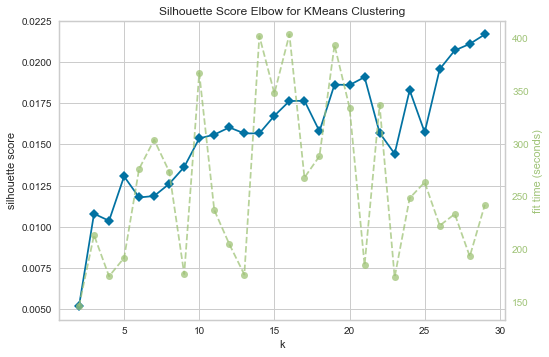

In [80]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)
visualizer = KElbowVisualizer(kmeans, metric='silhouette', k=(2,30))

visualizer.fit(x)    # Fit the data to the visualizer
visualizer.poof()

Initialization complete
Iteration  0, inertia 7727.674
Iteration  1, inertia 4222.775
Iteration  2, inertia 4187.962
Iteration  3, inertia 4171.113
Iteration  4, inertia 4163.408
Iteration  5, inertia 4159.007
Iteration  6, inertia 4156.844
Iteration  7, inertia 4155.463
Iteration  8, inertia 4154.590
Iteration  9, inertia 4154.171
Iteration 10, inertia 4153.743
Iteration 11, inertia 4153.370
Iteration 12, inertia 4152.834
Iteration 13, inertia 4152.606
Iteration 14, inertia 4152.507
Iteration 15, inertia 4152.385
Iteration 16, inertia 4152.261
Iteration 17, inertia 4152.174
Iteration 18, inertia 4152.160
Iteration 19, inertia 4152.142
Iteration 20, inertia 4152.088
Iteration 21, inertia 4152.083
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7650.104
Iteration  1, inertia 4229.978
Iteration  2, inertia 4200.509
Iteration  3, inertia 4184.728
Iteration  4, inertia 4173.359
Iteration  5, inertia 4167.464
I

Initialization complete
Iteration  0, inertia 7721.855
Iteration  1, inertia 4219.787
Iteration  2, inertia 4184.764
Iteration  3, inertia 4168.067
Iteration  4, inertia 4160.631
Iteration  5, inertia 4156.111
Iteration  6, inertia 4153.966
Iteration  7, inertia 4152.682
Iteration  8, inertia 4151.821
Iteration  9, inertia 4151.275
Iteration 10, inertia 4150.911
Iteration 11, inertia 4150.448
Iteration 12, inertia 4150.064
Iteration 13, inertia 4149.844
Iteration 14, inertia 4149.685
Iteration 15, inertia 4149.573
Iteration 16, inertia 4149.409
Iteration 17, inertia 4149.282
Iteration 18, inertia 4149.257
Iteration 19, inertia 4149.195
Iteration 20, inertia 4149.188
Iteration 21, inertia 4149.178
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4680.750
Iteration  1, inertia 4407.966
Iteration  2, inertia 4375.630
Iteration  3, inertia 4367.535
Iteration  4, inertia 4364.895
Iteration  5, inertia 4363.934
I

Iteration 12, inertia 4133.068
Iteration 13, inertia 4132.891
Iteration 14, inertia 4132.649
Iteration 15, inertia 4132.320
Iteration 16, inertia 4131.339
Iteration 17, inertia 4131.043
Iteration 18, inertia 4130.780
Iteration 19, inertia 4130.614
Iteration 20, inertia 4130.429
Iteration 21, inertia 4130.377
Iteration 22, inertia 4130.360
Iteration 23, inertia 4130.354
Iteration 24, inertia 4130.346
Converged at iteration 24: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4666.744
Iteration  1, inertia 4423.451
Iteration  2, inertia 4389.261
Iteration  3, inertia 4351.384
Iteration  4, inertia 4344.724
Iteration  5, inertia 4342.923
Iteration  6, inertia 4341.703
Iteration  7, inertia 4341.310
Iteration  8, inertia 4341.157
Iteration  9, inertia 4341.049
Iteration 10, inertia 4341.039
Iteration 11, inertia 4340.976
Iteration 12, inertia 4340.952
Iteration 13, inertia 4340.863
Iteration 14, inertia 4340.587
Iteration 15, inertia 434

Iteration  7, inertia 4140.236
Iteration  8, inertia 4139.526
Iteration  9, inertia 4138.642
Iteration 10, inertia 4137.689
Iteration 11, inertia 4135.479
Iteration 12, inertia 4135.215
Iteration 13, inertia 4135.117
Iteration 14, inertia 4135.104
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7708.582
Iteration  1, inertia 4217.089
Iteration  2, inertia 4178.666
Iteration  3, inertia 4162.848
Iteration  4, inertia 4153.969
Iteration  5, inertia 4148.873
Iteration  6, inertia 4145.645
Iteration  7, inertia 4143.375
Iteration  8, inertia 4141.636
Iteration  9, inertia 4140.397
Iteration 10, inertia 4139.527
Iteration 11, inertia 4138.885
Iteration 12, inertia 4138.479
Iteration 13, inertia 4138.258
Iteration 14, inertia 4137.966
Iteration 15, inertia 4137.796
Iteration 16, inertia 4137.715
Iteration 17, inertia 4137.708
Iteration 18, inertia 4137.688
Iteration 19, inertia 4137.668
Iteration 20, inertia 413

Iteration 13, inertia 4350.767
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7655.793
Iteration  1, inertia 4218.045
Iteration  2, inertia 4179.770
Iteration  3, inertia 4162.123
Iteration  4, inertia 4155.371
Iteration  5, inertia 4151.462
Iteration  6, inertia 4149.044
Iteration  7, inertia 4146.645
Iteration  8, inertia 4144.923
Iteration  9, inertia 4143.946
Iteration 10, inertia 4142.351
Iteration 11, inertia 4140.997
Iteration 12, inertia 4140.127
Iteration 13, inertia 4139.439
Iteration 14, inertia 4139.065
Iteration 15, inertia 4138.720
Iteration 16, inertia 4138.553
Iteration 17, inertia 4138.507
Converged at iteration 17: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7649.925
Iteration  1, inertia 4208.964
Iteration  2, inertia 4169.261
Iteration  3, inertia 4151.075
Iteration  4, inertia 4143.032
Iteration  5, inertia 4138.415
Iteration  

Iteration  8, inertia 4142.546
Iteration  9, inertia 4142.310
Iteration 10, inertia 4142.251
Iteration 11, inertia 4142.143
Iteration 12, inertia 4142.083
Iteration 13, inertia 4142.073
Iteration 14, inertia 4142.056
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7663.683
Iteration  1, inertia 4214.216
Iteration  2, inertia 4174.416
Iteration  3, inertia 4161.036
Iteration  4, inertia 4154.756
Iteration  5, inertia 4150.981
Iteration  6, inertia 4149.101
Iteration  7, inertia 4147.748
Iteration  8, inertia 4146.589
Iteration  9, inertia 4145.619
Iteration 10, inertia 4144.893
Iteration 11, inertia 4144.059
Iteration 12, inertia 4143.367
Iteration 13, inertia 4142.659
Iteration 14, inertia 4142.018
Iteration 15, inertia 4141.587
Iteration 16, inertia 4141.260
Iteration 17, inertia 4140.880
Iteration 18, inertia 4140.481
Iteration 19, inertia 4140.219
Iteration 20, inertia 4139.922
Iteration 21, inertia 413

Initialization complete
Iteration  0, inertia 7582.235
Iteration  1, inertia 4206.947
Iteration  2, inertia 4169.509
Iteration  3, inertia 4151.034
Iteration  4, inertia 4141.442
Iteration  5, inertia 4135.657
Iteration  6, inertia 4130.923
Iteration  7, inertia 4126.267
Iteration  8, inertia 4122.711
Iteration  9, inertia 4121.456
Iteration 10, inertia 4120.366
Iteration 11, inertia 4119.307
Iteration 12, inertia 4118.439
Iteration 13, inertia 4117.712
Iteration 14, inertia 4117.481
Iteration 15, inertia 4117.355
Iteration 16, inertia 4117.316
Iteration 17, inertia 4117.286
Iteration 18, inertia 4117.254
Iteration 19, inertia 4117.226
Iteration 20, inertia 4117.204
Iteration 21, inertia 4117.181
Iteration 22, inertia 4117.162
Iteration 23, inertia 4117.126
Iteration 24, inertia 4117.083
Iteration 25, inertia 4117.057
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7630.092
Iteration  1, inertia 4214.698
I

Iteration 18, inertia 4125.431
Iteration 19, inertia 4125.395
Converged at iteration 19: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7591.967
Iteration  1, inertia 4199.570
Iteration  2, inertia 4170.803
Iteration  3, inertia 4157.803
Iteration  4, inertia 4150.692
Iteration  5, inertia 4145.312
Iteration  6, inertia 4141.941
Iteration  7, inertia 4138.649
Iteration  8, inertia 4135.691
Iteration  9, inertia 4133.837
Iteration 10, inertia 4132.400
Iteration 11, inertia 4130.638
Iteration 12, inertia 4127.413
Iteration 13, inertia 4124.153
Iteration 14, inertia 4122.790
Iteration 15, inertia 4122.655
Iteration 16, inertia 4122.606
Converged at iteration 16: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7615.968
Iteration  1, inertia 4206.059
Iteration  2, inertia 4162.099
Iteration  3, inertia 4142.391
Iteration  4, inertia 4132.343
Iteration  5, inertia 4127.069
Iteration  

Iteration 24, inertia 4120.385
Iteration 25, inertia 4120.380
Iteration 26, inertia 4120.371
Converged at iteration 26: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7642.148
Iteration  1, inertia 4203.365
Iteration  2, inertia 4176.065
Iteration  3, inertia 4164.411
Iteration  4, inertia 4157.022
Iteration  5, inertia 4150.933
Iteration  6, inertia 4145.379
Iteration  7, inertia 4141.151
Iteration  8, inertia 4137.957
Iteration  9, inertia 4135.394
Iteration 10, inertia 4133.730
Iteration 11, inertia 4132.323
Iteration 12, inertia 4131.066
Iteration 13, inertia 4130.112
Iteration 14, inertia 4129.186
Iteration 15, inertia 4128.813
Iteration 16, inertia 4128.618
Iteration 17, inertia 4128.520
Iteration 18, inertia 4128.414
Iteration 19, inertia 4128.371
Iteration 20, inertia 4128.341
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4635.788
Iteration  

Iteration  2, inertia 4364.781
Iteration  3, inertia 4345.816
Iteration  4, inertia 4333.424
Iteration  5, inertia 4330.408
Iteration  6, inertia 4329.055
Iteration  7, inertia 4328.347
Iteration  8, inertia 4328.063
Iteration  9, inertia 4327.971
Iteration 10, inertia 4327.923
Iteration 11, inertia 4327.841
Iteration 12, inertia 4327.797
Converged at iteration 12: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7566.166
Iteration  1, inertia 4191.879
Iteration  2, inertia 4156.285
Iteration  3, inertia 4138.833
Iteration  4, inertia 4128.854
Iteration  5, inertia 4120.395
Iteration  6, inertia 4115.489
Iteration  7, inertia 4110.651
Iteration  8, inertia 4108.079
Iteration  9, inertia 4106.846
Iteration 10, inertia 4105.987
Iteration 11, inertia 4105.672
Iteration 12, inertia 4105.377
Iteration 13, inertia 4105.016
Iteration 14, inertia 4104.892
Iteration 15, inertia 4104.820
Iteration 16, inertia 4104.798
Iteration 17, inertia 410

Iteration  0, inertia 7564.726
Iteration  1, inertia 4199.719
Iteration  2, inertia 4157.157
Iteration  3, inertia 4139.059
Iteration  4, inertia 4129.098
Iteration  5, inertia 4122.440
Iteration  6, inertia 4118.926
Iteration  7, inertia 4116.440
Iteration  8, inertia 4113.964
Iteration  9, inertia 4112.934
Iteration 10, inertia 4111.560
Iteration 11, inertia 4110.674
Iteration 12, inertia 4110.437
Iteration 13, inertia 4110.300
Iteration 14, inertia 4110.071
Iteration 15, inertia 4109.904
Iteration 16, inertia 4109.772
Iteration 17, inertia 4109.669
Iteration 18, inertia 4109.608
Iteration 19, inertia 4109.499
Iteration 20, inertia 4109.369
Iteration 21, inertia 4109.210
Iteration 22, inertia 4109.135
Iteration 23, inertia 4109.116
Iteration 24, inertia 4109.098
Iteration 25, inertia 4109.080
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7577.342
Iteration  1, inertia 4190.396
Iteration  2, inertia 415

Initialization complete
Iteration  0, inertia 7546.849
Iteration  1, inertia 4171.374
Iteration  2, inertia 4134.449
Iteration  3, inertia 4117.654
Iteration  4, inertia 4109.331
Iteration  5, inertia 4103.512
Iteration  6, inertia 4098.827
Iteration  7, inertia 4096.043
Iteration  8, inertia 4093.538
Iteration  9, inertia 4092.860
Iteration 10, inertia 4091.501
Iteration 11, inertia 4091.197
Iteration 12, inertia 4090.689
Iteration 13, inertia 4090.485
Iteration 14, inertia 4090.400
Iteration 15, inertia 4090.314
Iteration 16, inertia 4090.174
Iteration 17, inertia 4090.065
Iteration 18, inertia 4090.006
Iteration 19, inertia 4089.927
Iteration 20, inertia 4089.775
Iteration 21, inertia 4089.642
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7551.461
Iteration  1, inertia 4182.041
Iteration  2, inertia 4147.283
Iteration  3, inertia 4133.098
Iteration  4, inertia 4125.206
Iteration  5, inertia 4117.654
I

Initialization complete
Iteration  0, inertia 7519.032
Iteration  1, inertia 4195.036
Iteration  2, inertia 4158.078
Iteration  3, inertia 4137.112
Iteration  4, inertia 4123.704
Iteration  5, inertia 4116.282
Iteration  6, inertia 4111.790
Iteration  7, inertia 4109.324
Iteration  8, inertia 4107.514
Iteration  9, inertia 4106.615
Iteration 10, inertia 4106.199
Iteration 11, inertia 4105.908
Iteration 12, inertia 4105.840
Iteration 13, inertia 4105.805
Iteration 14, inertia 4105.781
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7497.771
Iteration  1, inertia 4185.973
Iteration  2, inertia 4147.441
Iteration  3, inertia 4131.078
Iteration  4, inertia 4122.870
Iteration  5, inertia 4118.016
Iteration  6, inertia 4115.143
Iteration  7, inertia 4113.931
Iteration  8, inertia 4113.314
Iteration  9, inertia 4112.839
Iteration 10, inertia 4112.377
Iteration 11, inertia 4112.149
Iteration 12, inertia 4112.062
I

Iteration 12, inertia 4115.678
Iteration 13, inertia 4115.278
Iteration 14, inertia 4115.079
Iteration 15, inertia 4114.834
Iteration 16, inertia 4114.390
Iteration 17, inertia 4114.071
Iteration 18, inertia 4113.752
Iteration 19, inertia 4113.685
Iteration 20, inertia 4113.669
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7544.214
Iteration  1, inertia 4197.579
Iteration  2, inertia 4161.752
Iteration  3, inertia 4146.089
Iteration  4, inertia 4138.225
Iteration  5, inertia 4133.472
Iteration  6, inertia 4130.431
Iteration  7, inertia 4127.582
Iteration  8, inertia 4125.749
Iteration  9, inertia 4124.281
Iteration 10, inertia 4123.729
Iteration 11, inertia 4123.352
Iteration 12, inertia 4122.762
Iteration 13, inertia 4121.596
Iteration 14, inertia 4120.556
Iteration 15, inertia 4118.518
Iteration 16, inertia 4115.689
Iteration 17, inertia 4115.462
Converged at iteration 17: center shift 0.000000e+00 wit

Initialization complete
Iteration  0, inertia 7527.994
Iteration  1, inertia 4180.236
Iteration  2, inertia 4141.654
Iteration  3, inertia 4118.859
Iteration  4, inertia 4108.022
Iteration  5, inertia 4103.216
Iteration  6, inertia 4100.113
Iteration  7, inertia 4098.642
Iteration  8, inertia 4097.325
Iteration  9, inertia 4096.461
Iteration 10, inertia 4095.701
Iteration 11, inertia 4095.284
Iteration 12, inertia 4094.972
Iteration 13, inertia 4094.586
Iteration 14, inertia 4093.841
Iteration 15, inertia 4093.511
Iteration 16, inertia 4093.488
Iteration 17, inertia 4093.478
Iteration 18, inertia 4093.454
Iteration 19, inertia 4093.448
Iteration 20, inertia 4093.436
Iteration 21, inertia 4093.421
Iteration 22, inertia 4093.412
Converged at iteration 22: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7480.391
Iteration  1, inertia 4162.717
Iteration  2, inertia 4124.793
Iteration  3, inertia 4107.843
Iteration  4, inertia 4097.349
I

Iteration  6, inertia 4099.809
Iteration  7, inertia 4096.862
Iteration  8, inertia 4095.356
Iteration  9, inertia 4095.057
Iteration 10, inertia 4094.764
Iteration 11, inertia 4094.626
Iteration 12, inertia 4094.551
Iteration 13, inertia 4094.425
Iteration 14, inertia 4094.253
Iteration 15, inertia 4094.000
Iteration 16, inertia 4093.564
Iteration 17, inertia 4093.488
Iteration 18, inertia 4093.428
Iteration 19, inertia 4093.246
Iteration 20, inertia 4093.149
Iteration 21, inertia 4093.089
Iteration 22, inertia 4092.841
Iteration 23, inertia 4092.483
Iteration 24, inertia 4092.283
Iteration 25, inertia 4092.198
Iteration 26, inertia 4092.187
Iteration 27, inertia 4092.170
Converged at iteration 27: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7550.127
Iteration  1, inertia 4188.620
Iteration  2, inertia 4145.759
Iteration  3, inertia 4124.105
Iteration  4, inertia 4112.144
Iteration  5, inertia 4105.510
Iteration  6, inertia 410

Iteration 13, inertia 4105.382
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7590.224
Iteration  1, inertia 4161.682
Iteration  2, inertia 4123.815
Iteration  3, inertia 4110.756
Iteration  4, inertia 4102.023
Iteration  5, inertia 4096.330
Iteration  6, inertia 4091.950
Iteration  7, inertia 4089.710
Iteration  8, inertia 4088.490
Iteration  9, inertia 4087.146
Iteration 10, inertia 4086.292
Iteration 11, inertia 4085.535
Iteration 12, inertia 4084.950
Iteration 13, inertia 4084.799
Iteration 14, inertia 4084.686
Iteration 15, inertia 4084.528
Iteration 16, inertia 4084.487
Iteration 17, inertia 4084.443
Iteration 18, inertia 4084.428
Iteration 19, inertia 4084.409
Iteration 20, inertia 4084.391
Iteration 21, inertia 4084.383
Iteration 22, inertia 4084.374
Iteration 23, inertia 4084.357
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  

Initialization complete
Iteration  0, inertia 4626.041
Iteration  1, inertia 4347.742
Iteration  2, inertia 4317.243
Iteration  3, inertia 4303.439
Iteration  4, inertia 4299.292
Iteration  5, inertia 4295.762
Iteration  6, inertia 4292.688
Iteration  7, inertia 4291.477
Iteration  8, inertia 4290.754
Iteration  9, inertia 4290.079
Iteration 10, inertia 4289.804
Iteration 11, inertia 4289.681
Iteration 12, inertia 4289.645
Iteration 13, inertia 4289.638
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4638.006
Iteration  1, inertia 4361.882
Iteration  2, inertia 4331.808
Iteration  3, inertia 4324.395
Iteration  4, inertia 4322.126
Iteration  5, inertia 4321.471
Iteration  6, inertia 4320.874
Iteration  7, inertia 4320.865
Converged at iteration 7: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7545.712
Iteration  1, inertia 4168.431
Iteration  2, inert

Iteration 15, inertia 4253.887
Iteration 16, inertia 4253.666
Iteration 17, inertia 4253.491
Iteration 18, inertia 4253.190
Iteration 19, inertia 4252.828
Iteration 20, inertia 4252.726
Iteration 21, inertia 4252.652
Iteration 22, inertia 4252.540
Iteration 23, inertia 4252.411
Iteration 24, inertia 4252.250
Iteration 25, inertia 4251.803
Iteration 26, inertia 4250.374
Iteration 27, inertia 4246.029
Iteration 28, inertia 4240.765
Iteration 29, inertia 4236.063
Iteration 30, inertia 4233.193
Iteration 31, inertia 4231.120
Iteration 32, inertia 4230.070
Iteration 33, inertia 4229.410
Iteration 34, inertia 4228.931
Iteration 35, inertia 4228.740
Iteration 36, inertia 4228.633
Iteration 37, inertia 4228.528
Iteration 38, inertia 4228.477
Iteration 39, inertia 4228.432
Iteration 40, inertia 4228.386
Iteration 41, inertia 4228.372
Iteration 42, inertia 4228.362
Iteration 43, inertia 4228.357
Iteration 44, inertia 4228.352
Iteration 45, inertia 4228.349
Iteration 46, inertia 4228.343
Iteratio

Iteration  4, inertia 4101.102
Iteration  5, inertia 4095.418
Iteration  6, inertia 4091.668
Iteration  7, inertia 4088.983
Iteration  8, inertia 4086.957
Iteration  9, inertia 4085.514
Iteration 10, inertia 4085.064
Iteration 11, inertia 4084.617
Iteration 12, inertia 4084.172
Iteration 13, inertia 4084.038
Iteration 14, inertia 4083.951
Iteration 15, inertia 4083.926
Iteration 16, inertia 4083.903
Converged at iteration 16: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7518.129
Iteration  1, inertia 4172.078
Iteration  2, inertia 4137.738
Iteration  3, inertia 4117.962
Iteration  4, inertia 4107.296
Iteration  5, inertia 4101.569
Iteration  6, inertia 4097.538
Iteration  7, inertia 4094.798
Iteration  8, inertia 4093.478
Iteration  9, inertia 4093.018
Iteration 10, inertia 4092.074
Iteration 11, inertia 4091.752
Iteration 12, inertia 4091.618
Iteration 13, inertia 4091.563
Iteration 14, inertia 4091.510
Iteration 15, inertia 409

Iteration  9, inertia 4082.129
Iteration 10, inertia 4080.324
Iteration 11, inertia 4079.145
Iteration 12, inertia 4078.374
Iteration 13, inertia 4078.050
Iteration 14, inertia 4077.814
Iteration 15, inertia 4077.475
Iteration 16, inertia 4077.239
Iteration 17, inertia 4076.784
Iteration 18, inertia 4076.583
Converged at iteration 18: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7515.765
Iteration  1, inertia 4147.783
Iteration  2, inertia 4109.342
Iteration  3, inertia 4094.538
Iteration  4, inertia 4085.803
Iteration  5, inertia 4081.243
Iteration  6, inertia 4078.475
Iteration  7, inertia 4077.486
Iteration  8, inertia 4077.054
Iteration  9, inertia 4076.835
Iteration 10, inertia 4076.729
Iteration 11, inertia 4076.621
Iteration 12, inertia 4076.558
Iteration 13, inertia 4076.545
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7430.272
Iteration  

Iteration  4, inertia 4087.438
Iteration  5, inertia 4080.593
Iteration  6, inertia 4076.400
Iteration  7, inertia 4073.132
Iteration  8, inertia 4071.689
Iteration  9, inertia 4070.343
Iteration 10, inertia 4068.698
Iteration 11, inertia 4067.437
Iteration 12, inertia 4066.429
Iteration 13, inertia 4065.977
Iteration 14, inertia 4065.731
Iteration 15, inertia 4065.580
Iteration 16, inertia 4065.535
Iteration 17, inertia 4065.465
Iteration 18, inertia 4065.408
Iteration 19, inertia 4065.373
Iteration 20, inertia 4065.361
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7444.548
Iteration  1, inertia 4156.102
Iteration  2, inertia 4118.791
Iteration  3, inertia 4097.447
Iteration  4, inertia 4087.006
Iteration  5, inertia 4080.067
Iteration  6, inertia 4075.825
Iteration  7, inertia 4072.815
Iteration  8, inertia 4070.911
Iteration  9, inertia 4070.044
Iteration 10, inertia 4069.601
Iteration 11, inertia 406

Iteration 11, inertia 4062.060
Iteration 12, inertia 4061.621
Iteration 13, inertia 4061.317
Iteration 14, inertia 4061.089
Iteration 15, inertia 4060.993
Iteration 16, inertia 4060.971
Iteration 17, inertia 4060.962
Iteration 18, inertia 4060.951
Converged at iteration 18: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7435.450
Iteration  1, inertia 4151.908
Iteration  2, inertia 4115.757
Iteration  3, inertia 4094.499
Iteration  4, inertia 4083.190
Iteration  5, inertia 4076.133
Iteration  6, inertia 4072.469
Iteration  7, inertia 4069.796
Iteration  8, inertia 4068.468
Iteration  9, inertia 4067.615
Iteration 10, inertia 4067.208
Iteration 11, inertia 4066.995
Iteration 12, inertia 4066.747
Iteration 13, inertia 4066.542
Iteration 14, inertia 4066.300
Iteration 15, inertia 4065.944
Iteration 16, inertia 4064.901
Iteration 17, inertia 4064.599
Iteration 18, inertia 4064.519
Iteration 19, inertia 4064.491
Iteration 20, inertia 406

Iteration  6, inertia 4293.909
Iteration  7, inertia 4292.204
Iteration  8, inertia 4291.150
Iteration  9, inertia 4290.568
Iteration 10, inertia 4290.189
Iteration 11, inertia 4289.729
Iteration 12, inertia 4289.261
Iteration 13, inertia 4288.520
Iteration 14, inertia 4287.944
Iteration 15, inertia 4287.226
Iteration 16, inertia 4286.950
Iteration 17, inertia 4286.741
Iteration 18, inertia 4285.948
Iteration 19, inertia 4285.308
Iteration 20, inertia 4284.523
Iteration 21, inertia 4282.773
Iteration 22, inertia 4279.771
Iteration 23, inertia 4276.945
Iteration 24, inertia 4274.512
Iteration 25, inertia 4272.847
Iteration 26, inertia 4271.908
Iteration 27, inertia 4271.363
Iteration 28, inertia 4271.064
Iteration 29, inertia 4270.969
Iteration 30, inertia 4270.948
Iteration 31, inertia 4270.943
Converged at iteration 31: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7424.283
Iteration  1, inertia 4137.184
Iteration  2, inertia 409

Iteration 43, inertia 4225.246
Iteration 44, inertia 4224.306
Iteration 45, inertia 4222.957
Iteration 46, inertia 4222.149
Iteration 47, inertia 4221.798
Iteration 48, inertia 4221.470
Iteration 49, inertia 4220.785
Iteration 50, inertia 4219.289
Iteration 51, inertia 4217.993
Iteration 52, inertia 4217.540
Iteration 53, inertia 4217.262
Iteration 54, inertia 4217.117
Iteration 55, inertia 4216.999
Iteration 56, inertia 4216.968
Iteration 57, inertia 4216.954
Iteration 58, inertia 4216.949
Iteration 59, inertia 4216.948
Converged at iteration 59: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7396.547
Iteration  1, inertia 4134.199
Iteration  2, inertia 4102.440
Iteration  3, inertia 4089.325
Iteration  4, inertia 4079.713
Iteration  5, inertia 4072.052
Iteration  6, inertia 4065.972
Iteration  7, inertia 4061.706
Iteration  8, inertia 4060.496
Iteration  9, inertia 4060.108
Iteration 10, inertia 4059.861
Iteration 11, inertia 405

Iteration 17, inertia 4052.032
Iteration 18, inertia 4051.944
Iteration 19, inertia 4051.836
Iteration 20, inertia 4051.770
Iteration 21, inertia 4051.750
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7425.598
Iteration  1, inertia 4150.535
Iteration  2, inertia 4111.445
Iteration  3, inertia 4093.091
Iteration  4, inertia 4083.440
Iteration  5, inertia 4078.259
Iteration  6, inertia 4075.291
Iteration  7, inertia 4074.073
Iteration  8, inertia 4073.499
Iteration  9, inertia 4073.262
Iteration 10, inertia 4073.093
Iteration 11, inertia 4072.964
Iteration 12, inertia 4072.836
Iteration 13, inertia 4072.751
Iteration 14, inertia 4072.739
Iteration 15, inertia 4072.728
Converged at iteration 15: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7446.985
Iteration  1, inertia 4135.178
Iteration  2, inertia 4102.184
Iteration  3, inertia 4086.171
Iteration  

Iteration  0, inertia 7397.857
Iteration  1, inertia 4136.890
Iteration  2, inertia 4100.140
Iteration  3, inertia 4078.353
Iteration  4, inertia 4067.114
Iteration  5, inertia 4060.100
Iteration  6, inertia 4056.332
Iteration  7, inertia 4054.056
Iteration  8, inertia 4052.926
Iteration  9, inertia 4052.432
Iteration 10, inertia 4052.133
Iteration 11, inertia 4051.939
Iteration 12, inertia 4051.779
Iteration 13, inertia 4051.678
Iteration 14, inertia 4051.270
Iteration 15, inertia 4050.771
Iteration 16, inertia 4049.566
Iteration 17, inertia 4049.442
Iteration 18, inertia 4049.371
Iteration 19, inertia 4049.262
Iteration 20, inertia 4049.190
Iteration 21, inertia 4049.039
Iteration 22, inertia 4048.911
Iteration 23, inertia 4048.872
Iteration 24, inertia 4048.662
Iteration 25, inertia 4048.485
Iteration 26, inertia 4048.464
Converged at iteration 26: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7459.923
Iteration  1, inertia 412

Initialization complete
Iteration  0, inertia 7456.849
Iteration  1, inertia 4118.994
Iteration  2, inertia 4078.236
Iteration  3, inertia 4060.857
Iteration  4, inertia 4052.898
Iteration  5, inertia 4049.045
Iteration  6, inertia 4046.860
Iteration  7, inertia 4045.675
Iteration  8, inertia 4045.164
Iteration  9, inertia 4044.913
Iteration 10, inertia 4044.826
Iteration 11, inertia 4044.819
Converged at iteration 11: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7434.068
Iteration  1, inertia 4128.169
Iteration  2, inertia 4088.279
Iteration  3, inertia 4073.994
Iteration  4, inertia 4065.762
Iteration  5, inertia 4060.208
Iteration  6, inertia 4055.517
Iteration  7, inertia 4052.233
Iteration  8, inertia 4049.689
Iteration  9, inertia 4047.413
Iteration 10, inertia 4046.431
Iteration 11, inertia 4045.557
Iteration 12, inertia 4044.657
Iteration 13, inertia 4043.960
Iteration 14, inertia 4043.462
Iteration 15, inertia 4043.091
I

Initialization complete
Iteration  0, inertia 7435.737
Iteration  1, inertia 4115.339
Iteration  2, inertia 4081.475
Iteration  3, inertia 4066.177
Iteration  4, inertia 4058.976
Iteration  5, inertia 4055.828
Iteration  6, inertia 4053.740
Iteration  7, inertia 4052.218
Iteration  8, inertia 4050.840
Iteration  9, inertia 4050.454
Iteration 10, inertia 4050.244
Iteration 11, inertia 4050.145
Iteration 12, inertia 4050.063
Iteration 13, inertia 4050.027
Iteration 14, inertia 4050.003
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7406.446
Iteration  1, inertia 4121.700
Iteration  2, inertia 4085.388
Iteration  3, inertia 4067.038
Iteration  4, inertia 4057.271
Iteration  5, inertia 4049.706
Iteration  6, inertia 4045.253
Iteration  7, inertia 4042.833
Iteration  8, inertia 4041.152
Iteration  9, inertia 4040.657
Iteration 10, inertia 4040.486
Iteration 11, inertia 4040.380
Iteration 12, inertia 4040.311
I

Iteration 14, inertia 4029.059
Iteration 15, inertia 4028.979
Iteration 16, inertia 4028.894
Iteration 17, inertia 4028.677
Iteration 18, inertia 4028.551
Iteration 19, inertia 4028.430
Iteration 20, inertia 4028.399
Iteration 21, inertia 4028.360
Iteration 22, inertia 4028.339
Iteration 23, inertia 4028.321
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4593.097
Iteration  1, inertia 4308.851
Iteration  2, inertia 4285.524
Iteration  3, inertia 4271.960
Iteration  4, inertia 4262.153
Iteration  5, inertia 4260.194
Iteration  6, inertia 4259.349
Iteration  7, inertia 4258.938
Iteration  8, inertia 4258.635
Iteration  9, inertia 4258.266
Iteration 10, inertia 4257.988
Iteration 11, inertia 4257.868
Iteration 12, inertia 4257.707
Iteration 13, inertia 4257.410
Iteration 14, inertia 4257.021
Iteration 15, inertia 4256.718
Iteration 16, inertia 4256.364
Iteration 17, inertia 4256.063
Iteration 18, inertia 425

Initialization complete
Iteration  0, inertia 7353.810
Iteration  1, inertia 4111.542
Iteration  2, inertia 4067.904
Iteration  3, inertia 4054.069
Iteration  4, inertia 4046.181
Iteration  5, inertia 4040.825
Iteration  6, inertia 4038.274
Iteration  7, inertia 4036.731
Iteration  8, inertia 4035.693
Iteration  9, inertia 4035.111
Iteration 10, inertia 4034.759
Iteration 11, inertia 4034.454
Iteration 12, inertia 4033.834
Iteration 13, inertia 4033.615
Iteration 14, inertia 4033.471
Iteration 15, inertia 4033.405
Iteration 16, inertia 4033.364
Iteration 17, inertia 4033.350
Iteration 18, inertia 4033.304
Iteration 19, inertia 4033.260
Iteration 20, inertia 4033.238
Iteration 21, inertia 4033.092
Iteration 22, inertia 4032.799
Iteration 23, inertia 4032.700
Iteration 24, inertia 4032.661
Iteration 25, inertia 4032.630
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4634.057
Iteration  1, inertia 4350.744
I

Iteration  3, inertia 4059.068
Iteration  4, inertia 4049.094
Iteration  5, inertia 4043.870
Iteration  6, inertia 4040.416
Iteration  7, inertia 4038.645
Iteration  8, inertia 4036.442
Iteration  9, inertia 4034.406
Iteration 10, inertia 4032.708
Iteration 11, inertia 4031.507
Iteration 12, inertia 4031.250
Iteration 13, inertia 4030.825
Iteration 14, inertia 4030.721
Iteration 15, inertia 4030.689
Iteration 16, inertia 4030.669
Iteration 17, inertia 4030.660
Converged at iteration 17: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7456.035
Iteration  1, inertia 4126.506
Iteration  2, inertia 4091.206
Iteration  3, inertia 4074.912
Iteration  4, inertia 4066.794
Iteration  5, inertia 4061.338
Iteration  6, inertia 4058.319
Iteration  7, inertia 4056.653
Iteration  8, inertia 4055.330
Iteration  9, inertia 4054.475
Iteration 10, inertia 4053.695
Iteration 11, inertia 4053.532
Converged at iteration 11: center shift 0.000000e+00 wit

Iteration 17, inertia 4035.122
Iteration 18, inertia 4034.847
Iteration 19, inertia 4034.579
Iteration 20, inertia 4034.405
Iteration 21, inertia 4034.354
Iteration 22, inertia 4034.331
Iteration 23, inertia 4034.307
Iteration 24, inertia 4034.285
Iteration 25, inertia 4034.263
Iteration 26, inertia 4034.245
Converged at iteration 26: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4621.636
Iteration  1, inertia 4323.172
Iteration  2, inertia 4285.825
Iteration  3, inertia 4260.568
Iteration  4, inertia 4246.358
Iteration  5, inertia 4243.319
Iteration  6, inertia 4242.600
Iteration  7, inertia 4242.230
Iteration  8, inertia 4241.911
Iteration  9, inertia 4241.847
Iteration 10, inertia 4241.765
Iteration 11, inertia 4241.721
Iteration 12, inertia 4241.702
Iteration 13, inertia 4241.695
Iteration 14, inertia 4241.688
Iteration 15, inertia 4241.673
Iteration 16, inertia 4241.659
Iteration 17, inertia 4241.634
Converged at iteration 17

Iteration 26, inertia 4194.690
Iteration 27, inertia 4194.653
Iteration 28, inertia 4194.638
Iteration 29, inertia 4194.629
Iteration 30, inertia 4194.553
Iteration 31, inertia 4194.491
Iteration 32, inertia 4194.489
Converged at iteration 32: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7383.962
Iteration  1, inertia 4116.771
Iteration  2, inertia 4078.633
Iteration  3, inertia 4063.059
Iteration  4, inertia 4055.813
Iteration  5, inertia 4051.631
Iteration  6, inertia 4047.849
Iteration  7, inertia 4045.776
Iteration  8, inertia 4044.485
Iteration  9, inertia 4043.906
Iteration 10, inertia 4043.437
Iteration 11, inertia 4043.288
Iteration 12, inertia 4043.224
Iteration 13, inertia 4043.195
Iteration 14, inertia 4043.173
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7395.859
Iteration  1, inertia 4112.888
Iteration  2, inertia 4071.229
Iteration  

Iteration  2, inertia 4075.621
Iteration  3, inertia 4059.826
Iteration  4, inertia 4051.597
Iteration  5, inertia 4046.910
Iteration  6, inertia 4043.391
Iteration  7, inertia 4041.442
Iteration  8, inertia 4039.433
Iteration  9, inertia 4038.116
Iteration 10, inertia 4037.261
Iteration 11, inertia 4035.727
Iteration 12, inertia 4032.761
Iteration 13, inertia 4027.032
Iteration 14, inertia 4026.403
Iteration 15, inertia 4026.232
Iteration 16, inertia 4026.041
Iteration 17, inertia 4025.870
Iteration 18, inertia 4025.751
Iteration 19, inertia 4025.607
Iteration 20, inertia 4025.310
Iteration 21, inertia 4025.180
Iteration 22, inertia 4025.158
Iteration 23, inertia 4025.074
Iteration 24, inertia 4025.050
Iteration 25, inertia 4025.022
Iteration 26, inertia 4024.976
Converged at iteration 26: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7325.177
Iteration  1, inertia 4101.417
Iteration  2, inertia 4060.902
Iteration  3, inertia 404

Iteration 17, inertia 4014.089
Converged at iteration 17: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7367.141
Iteration  1, inertia 4116.279
Iteration  2, inertia 4073.365
Iteration  3, inertia 4057.735
Iteration  4, inertia 4050.493
Iteration  5, inertia 4046.510
Iteration  6, inertia 4044.794
Iteration  7, inertia 4043.574
Iteration  8, inertia 4043.043
Iteration  9, inertia 4042.766
Iteration 10, inertia 4042.356
Iteration 11, inertia 4042.220
Iteration 12, inertia 4042.093
Iteration 13, inertia 4042.056
Iteration 14, inertia 4042.010
Iteration 15, inertia 4041.975
Iteration 16, inertia 4041.963
Iteration 17, inertia 4041.950
Iteration 18, inertia 4041.937
Converged at iteration 18: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7428.511
Iteration  1, inertia 4113.284
Iteration  2, inertia 4074.788
Iteration  3, inertia 4059.942
Iteration  4, inertia 4051.972
Iteration  

Iteration 13, inertia 4010.665
Iteration 14, inertia 4010.652
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7319.293
Iteration  1, inertia 4100.699
Iteration  2, inertia 4063.675
Iteration  3, inertia 4049.209
Iteration  4, inertia 4040.525
Iteration  5, inertia 4033.575
Iteration  6, inertia 4029.661
Iteration  7, inertia 4027.659
Iteration  8, inertia 4026.112
Iteration  9, inertia 4024.699
Iteration 10, inertia 4023.948
Iteration 11, inertia 4023.316
Iteration 12, inertia 4022.943
Iteration 13, inertia 4022.570
Iteration 14, inertia 4022.083
Iteration 15, inertia 4021.762
Iteration 16, inertia 4021.198
Iteration 17, inertia 4021.012
Iteration 18, inertia 4020.875
Iteration 19, inertia 4020.650
Iteration 20, inertia 4020.224
Iteration 21, inertia 4019.669
Iteration 22, inertia 4018.720
Iteration 23, inertia 4018.661
Iteration 24, inertia 4018.623
Iteration 25, inertia 4018.533
Iteration 26, inertia 401

Iteration  8, inertia 4034.857
Iteration  9, inertia 4033.442
Iteration 10, inertia 4032.137
Iteration 11, inertia 4030.912
Iteration 12, inertia 4029.678
Iteration 13, inertia 4028.846
Iteration 14, inertia 4028.033
Iteration 15, inertia 4027.159
Iteration 16, inertia 4026.589
Iteration 17, inertia 4025.809
Iteration 18, inertia 4025.368
Iteration 19, inertia 4025.149
Iteration 20, inertia 4024.855
Iteration 21, inertia 4024.642
Iteration 22, inertia 4024.088
Iteration 23, inertia 4023.502
Iteration 24, inertia 4023.290
Iteration 25, inertia 4023.224
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7314.006
Iteration  1, inertia 4096.522
Iteration  2, inertia 4061.891
Iteration  3, inertia 4050.648
Iteration  4, inertia 4045.291
Iteration  5, inertia 4042.239
Iteration  6, inertia 4040.388
Iteration  7, inertia 4039.340
Iteration  8, inertia 4038.639
Iteration  9, inertia 4038.322
Iteration 10, inertia 403

Iteration  2, inertia 4056.136
Iteration  3, inertia 4041.659
Iteration  4, inertia 4033.176
Iteration  5, inertia 4026.802
Iteration  6, inertia 4023.531
Iteration  7, inertia 4021.290
Iteration  8, inertia 4019.795
Iteration  9, inertia 4018.433
Iteration 10, inertia 4017.647
Iteration 11, inertia 4016.868
Iteration 12, inertia 4016.203
Iteration 13, inertia 4015.818
Iteration 14, inertia 4015.627
Iteration 15, inertia 4015.455
Iteration 16, inertia 4015.383
Iteration 17, inertia 4015.266
Iteration 18, inertia 4015.189
Iteration 19, inertia 4015.125
Iteration 20, inertia 4015.068
Iteration 21, inertia 4015.061
Converged at iteration 21: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7338.947
Iteration  1, inertia 4089.169
Iteration  2, inertia 4058.749
Iteration  3, inertia 4043.566
Iteration  4, inertia 4034.198
Iteration  5, inertia 4030.922
Iteration  6, inertia 4028.474
Iteration  7, inertia 4026.622
Iteration  8, inertia 402

Iteration  5, inertia 4012.177
Iteration  6, inertia 4008.758
Iteration  7, inertia 4006.020
Iteration  8, inertia 4003.858
Iteration  9, inertia 4002.589
Iteration 10, inertia 4001.517
Iteration 11, inertia 4000.882
Iteration 12, inertia 4000.525
Iteration 13, inertia 4000.105
Iteration 14, inertia 4000.039
Iteration 15, inertia 4000.023
Converged at iteration 15: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4582.005
Iteration  1, inertia 4275.573
Iteration  2, inertia 4235.370
Iteration  3, inertia 4223.657
Iteration  4, inertia 4217.396
Iteration  5, inertia 4214.414
Iteration  6, inertia 4214.066
Iteration  7, inertia 4213.955
Iteration  8, inertia 4213.916
Iteration  9, inertia 4213.824
Iteration 10, inertia 4213.791
Converged at iteration 10: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4588.262
Iteration  1, inertia 4279.111
Iteration  2, inertia 4240.339
Iteration  

Iteration  7, inertia 4015.400
Iteration  8, inertia 4014.071
Iteration  9, inertia 4012.948
Iteration 10, inertia 4012.136
Iteration 11, inertia 4011.541
Iteration 12, inertia 4010.938
Iteration 13, inertia 4010.460
Iteration 14, inertia 4010.105
Iteration 15, inertia 4009.917
Iteration 16, inertia 4009.806
Iteration 17, inertia 4009.749
Iteration 18, inertia 4009.702
Iteration 19, inertia 4009.641
Iteration 20, inertia 4009.593
Iteration 21, inertia 4009.536
Iteration 22, inertia 4009.494
Iteration 23, inertia 4009.448
Iteration 24, inertia 4009.405
Converged at iteration 24: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7293.601
Iteration  1, inertia 4082.513
Iteration  2, inertia 4043.485
Iteration  3, inertia 4026.516
Iteration  4, inertia 4018.478
Iteration  5, inertia 4013.421
Iteration  6, inertia 4011.029
Iteration  7, inertia 4007.953
Iteration  8, inertia 4006.233
Iteration  9, inertia 4005.018
Iteration 10, inertia 400

Iteration 14, inertia 4005.223
Iteration 15, inertia 4005.212
Converged at iteration 15: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7287.050
Iteration  1, inertia 4084.852
Iteration  2, inertia 4047.714
Iteration  3, inertia 4033.134
Iteration  4, inertia 4024.001
Iteration  5, inertia 4017.292
Iteration  6, inertia 4013.208
Iteration  7, inertia 4010.936
Iteration  8, inertia 4009.229
Iteration  9, inertia 4008.195
Iteration 10, inertia 4007.303
Iteration 11, inertia 4006.916
Iteration 12, inertia 4006.301
Iteration 13, inertia 4005.610
Iteration 14, inertia 4005.111
Iteration 15, inertia 4004.727
Iteration 16, inertia 4004.563
Iteration 17, inertia 4004.477
Iteration 18, inertia 4004.461
Iteration 19, inertia 4004.414
Iteration 20, inertia 4004.354
Iteration 21, inertia 4004.285
Iteration 22, inertia 4004.244
Iteration 23, inertia 4004.202
Iteration 24, inertia 4004.156
Iteration 25, inertia 4004.113
Converged at iteration 25

Iteration 12, inertia 4001.807
Iteration 13, inertia 4001.044
Iteration 14, inertia 4000.588
Iteration 15, inertia 4000.459
Iteration 16, inertia 4000.344
Iteration 17, inertia 4000.152
Iteration 18, inertia 4000.048
Iteration 19, inertia 4000.009
Converged at iteration 19: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 4560.610
Iteration  1, inertia 4283.838
Iteration  2, inertia 4250.508
Iteration  3, inertia 4240.342
Iteration  4, inertia 4236.049
Iteration  5, inertia 4233.466
Iteration  6, inertia 4232.082
Iteration  7, inertia 4231.529
Iteration  8, inertia 4231.373
Iteration  9, inertia 4231.272
Iteration 10, inertia 4231.230
Iteration 11, inertia 4231.144
Iteration 12, inertia 4231.059
Iteration 13, inertia 4231.024
Iteration 14, inertia 4230.980
Iteration 15, inertia 4230.962
Iteration 16, inertia 4230.954
Converged at iteration 16: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  

Iteration  5, inertia 4013.108
Iteration  6, inertia 4011.034
Iteration  7, inertia 4009.410
Iteration  8, inertia 4008.774
Iteration  9, inertia 4008.148
Iteration 10, inertia 4007.664
Iteration 11, inertia 4007.296
Iteration 12, inertia 4006.754
Iteration 13, inertia 4006.724
Iteration 14, inertia 4006.676
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7247.413
Iteration  1, inertia 4073.840
Iteration  2, inertia 4042.415
Iteration  3, inertia 4026.654
Iteration  4, inertia 4016.597
Iteration  5, inertia 4010.074
Iteration  6, inertia 4006.121
Iteration  7, inertia 4003.326
Iteration  8, inertia 4001.215
Iteration  9, inertia 4000.223
Iteration 10, inertia 3998.944
Iteration 11, inertia 3997.995
Iteration 12, inertia 3997.389
Iteration 13, inertia 3997.126
Iteration 14, inertia 3996.966
Iteration 15, inertia 3996.730
Iteration 16, inertia 3996.644
Iteration 17, inertia 3996.591
Converged at iteration 17

Initialization complete
Iteration  0, inertia 4547.287
Iteration  1, inertia 4260.641
Iteration  2, inertia 4241.575
Iteration  3, inertia 4229.626
Iteration  4, inertia 4223.866
Iteration  5, inertia 4222.173
Iteration  6, inertia 4220.970
Iteration  7, inertia 4220.581
Iteration  8, inertia 4220.454
Iteration  9, inertia 4220.400
Iteration 10, inertia 4220.358
Converged at iteration 10: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7273.902
Iteration  1, inertia 4073.703
Iteration  2, inertia 4035.943
Iteration  3, inertia 4021.187
Iteration  4, inertia 4012.638
Iteration  5, inertia 4007.618
Iteration  6, inertia 4003.564
Iteration  7, inertia 4000.964
Iteration  8, inertia 3997.274
Iteration  9, inertia 3996.573
Iteration 10, inertia 3996.136
Iteration 11, inertia 3995.620
Iteration 12, inertia 3994.965
Iteration 13, inertia 3994.472
Iteration 14, inertia 3993.952
Iteration 15, inertia 3993.326
Iteration 16, inertia 3992.483
I

Iteration 11, inertia 4209.274
Iteration 12, inertia 4209.218
Iteration 13, inertia 4209.182
Iteration 14, inertia 4209.069
Iteration 15, inertia 4209.024
Iteration 16, inertia 4208.950
Iteration 17, inertia 4208.902
Iteration 18, inertia 4208.880
Iteration 19, inertia 4208.849
Iteration 20, inertia 4208.840
Iteration 21, inertia 4208.835
Iteration 22, inertia 4208.825
Iteration 23, inertia 4208.820
Iteration 24, inertia 4208.811
Converged at iteration 24: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7324.517
Iteration  1, inertia 4066.222
Iteration  2, inertia 4025.845
Iteration  3, inertia 4009.282
Iteration  4, inertia 4001.787
Iteration  5, inertia 3996.444
Iteration  6, inertia 3992.421
Iteration  7, inertia 3990.310
Iteration  8, inertia 3989.436
Iteration  9, inertia 3988.146
Iteration 10, inertia 3987.182
Iteration 11, inertia 3987.043
Iteration 12, inertia 3986.981
Iteration 13, inertia 3986.664
Iteration 14, inertia 398

Iteration  6, inertia 4015.272
Iteration  7, inertia 4012.972
Iteration  8, inertia 4011.697
Iteration  9, inertia 4010.984
Iteration 10, inertia 4010.010
Iteration 11, inertia 4009.277
Iteration 12, inertia 4008.356
Iteration 13, inertia 4006.884
Iteration 14, inertia 4005.894
Iteration 15, inertia 4005.436
Iteration 16, inertia 4005.000
Iteration 17, inertia 4003.689
Iteration 18, inertia 4003.364
Iteration 19, inertia 4002.352
Iteration 20, inertia 4002.280
Converged at iteration 20: center shift 0.000000e+00 within tolerance 2.269238e-09
Initialization complete
Iteration  0, inertia 7273.737
Iteration  1, inertia 4070.554
Iteration  2, inertia 4035.082
Iteration  3, inertia 4020.214
Iteration  4, inertia 4012.554
Iteration  5, inertia 4008.042
Iteration  6, inertia 4005.382
Iteration  7, inertia 4003.641
Iteration  8, inertia 4002.829
Iteration  9, inertia 4002.203
Iteration 10, inertia 4001.398
Iteration 11, inertia 4000.856
Iteration 12, inertia 4000.522
Iteration 13, inertia 400

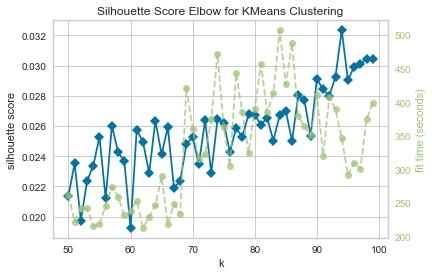

In [7]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++',max_iter=100,n_init=10,random_state=0, verbose=True)
visualizer = KElbowVisualizer(kmeans, metric='silhouette', k=(50,100))

visualizer.fit(x)    # Fit the data to the visualizer
visualizer.poof()

3.3 Use Optimal K-Value to run clustering

Load backup kmeans model

In [3]:
import pickle
with open('kmeans_model(K=24)', 'rb') as f:
    kmeans = pickle.load(f)
true_k = 24

In [257]:
from sklearn.cluster import MiniBatchKMeans, KMeans
true_k = 10

kmeans = MiniBatchKMeans(n_clusters=true_k, 
                         init='k-means++', 
                         n_init=10,
                         random_state=10,
                         init_size=1000, 
                         batch_size=1000,
                         verbose=True)

#kmeans = KMeans(n_clusters=true_k,init='k-means++',max_iter=100,n_init=10,random_state=1, verbose=True)
kmeans.fit(x)

import pickle
with open('kmeans_model(K=10)(1)', 'wb') as f: #94 24 15
    pickle.dump(kmeans, f)

Init 1/10 with method: k-means++
Inertia for init 1/10: 878.218556
Init 2/10 with method: k-means++
Inertia for init 2/10: 882.943295
Init 3/10 with method: k-means++
Inertia for init 3/10: 882.486954
Init 4/10 with method: k-means++
Inertia for init 4/10: 879.749835
Init 5/10 with method: k-means++
Inertia for init 5/10: 878.251623
Init 6/10 with method: k-means++
Inertia for init 6/10: 885.201700
Init 7/10 with method: k-means++
Inertia for init 7/10: 878.718051
Init 8/10 with method: k-means++
Inertia for init 8/10: 885.287749
Init 9/10 with method: k-means++
Inertia for init 9/10: 878.828820
Init 10/10 with method: k-means++
Inertia for init 10/10: 876.386442
Minibatch iteration 1/500: mean batch inertia: 0.898734, ewa inertia: 0.898734 
Minibatch iteration 2/500: mean batch inertia: 0.890202, ewa inertia: 0.895200 
Minibatch iteration 3/500: mean batch inertia: 0.885655, ewa inertia: 0.891246 
Minibatch iteration 4/500: mean batch inertia: 0.882993, ewa inertia: 0.887827 
Minibatc

In [258]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
top_terms = ""
top_terms_arr = []

for i in range(true_k):
    for ind in order_centroids[i, :15]:
        top_terms += terms[ind] + ', ' 
    print('Cluster %d:' % i + '>> ' + top_terms + '\n')
    top_terms_arr.append(top_terms)
    top_terms = ""

Cluster 0:>> orac, databas, expery, unix, serv, sql, admin, stor, knowledg, skil, support, linux, man, perform, backup, 

Cluster 1:>> develop, team, produc, expery, work, technolog, softw, solv, engin, design, man, apply, architect, cloud, techn, 

Cluster 2:>> test, infotech, greet, expery, autom, pleas, infotechposit, regard, defect, singaporecompany, bas, monthjd, inform, year, cli, 

Cluster 3:>> develop, design, expery, web, apply, jav, ap, softw, cod, requir, test, work, knowledg, program, framework, 

Cluster 4:>> network, support, serv, hardw, man, provid, troubleshoot, infrastruct, comput, window, requir, op, softw, expery, instal, 

Cluster 5:>> man, project, busy, custom, sal, team, work, expery, solv, requir, develop, cli, abl, lead, serv, 

Cluster 6:>> dat, busy, analys, expery, model, man, solv, big, team, develop, work, bank, skil, requir, process, 

Cluster 7:>> sec, cyb, vuln, assess, advert, job, inform, man, incid, cli, penet, cybersec, consult, risk, threat, 

Clu

In [260]:
import random
r = lambda: random.randint(0,255)

cluster_names = []
cluster_colors = []

for i in range(1,(true_k+1)):
    cluster_names.append(str(i) + ": " + top_terms_arr[i-1])
    cluster_colors.append('#%02X%02X%02X' % (r(),r(),r()))
print(cluster_names)
print(cluster_colors)

['1: orac, databas, expery, unix, serv, sql, admin, stor, knowledg, skil, support, linux, man, perform, backup, ', '2: develop, team, produc, expery, work, technolog, softw, solv, engin, design, man, apply, architect, cloud, techn, ', '3: test, infotech, greet, expery, autom, pleas, infotechposit, regard, defect, singaporecompany, bas, monthjd, inform, year, cli, ', '4: develop, design, expery, web, apply, jav, ap, softw, cod, requir, test, work, knowledg, program, framework, ', '5: network, support, serv, hardw, man, provid, troubleshoot, infrastruct, comput, window, requir, op, softw, expery, instal, ', '6: man, project, busy, custom, sal, team, work, expery, solv, requir, develop, cli, abl, lead, serv, ', '7: dat, busy, analys, expery, model, man, solv, big, team, develop, work, bank, skil, requir, process, ', '8: sec, cyb, vuln, assess, advert, job, inform, man, incid, cli, penet, cybersec, consult, risk, threat, ', '9: sap, expery, busy, abap, project, consult, develop, impl, man,

C:\Users\uSER\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


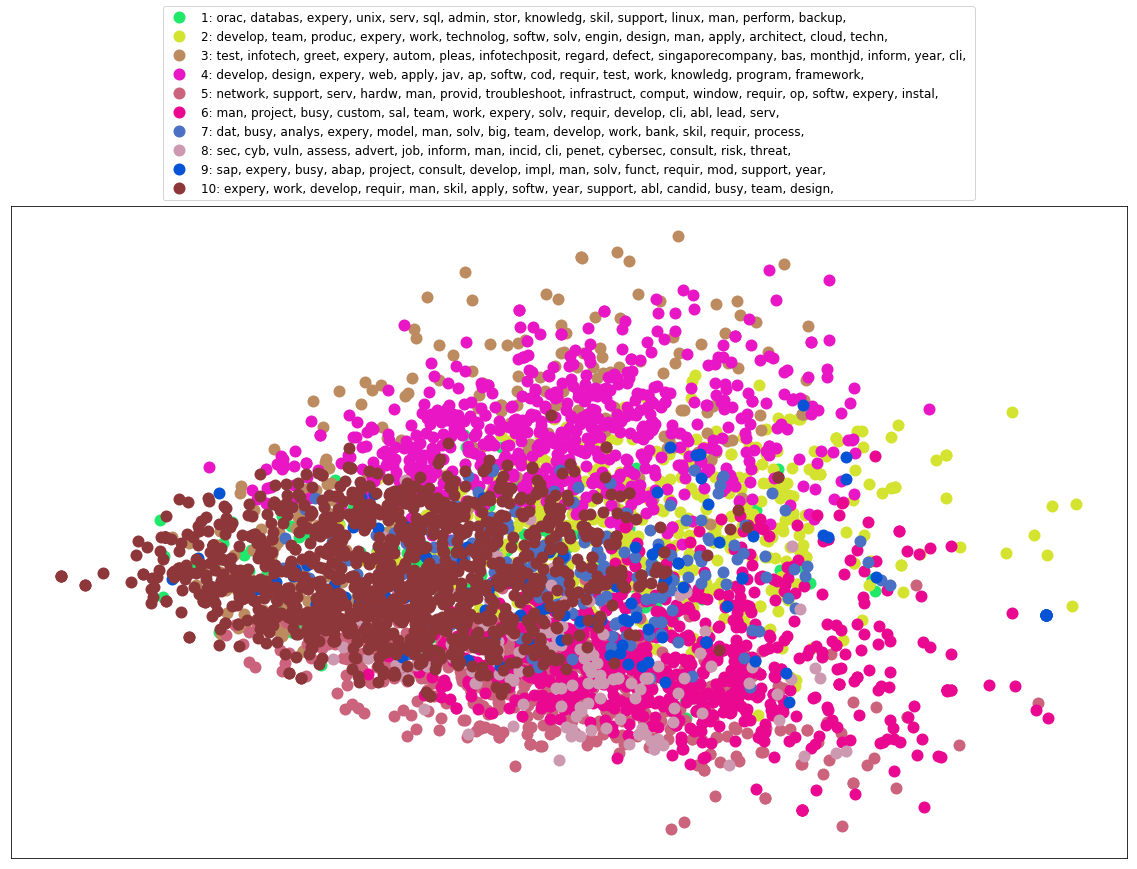

In [262]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
clusters = kmeans.labels_.tolist()
df = pd.DataFrame(dict(x=data2D[:, 0], y=data2D[:, 1], label=clusters)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(20, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
#ax.legend()  #show legend with only 1 point
ax.legend(numpoints=1, loc='lower center', bbox_to_anchor=(0.5, 1.00), prop={'size': 12})
#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], size=8)  

    
plt.show() #show the plot